In [10]:
import os
import itertools
from benchmarkrewriter.benchmark_parser import BenchmarkParser, WorkerBenchmarkParser, WorkerEncoding
import json
import pandas as pd
import math

In [28]:
FILTER_SDATA = True

In [11]:
#benchmark_path = '/home/dhu/Downloads/benchmarks_with_workers'
#results_path = '/home/dhu/Downloads/results/'
#ga_path = '/home/dhu/Downloads/ga_results/'
#results_path = r'C:\Users\huda\Downloads\results\\'
results_path = r'C:\Users\huda\Downloads\paper_results\paper_results\fjssp-w\\'
ga_path = r'C:\Users\huda\Downloads\ga_worker_results\ga_worker_results_rewritten\\'
#benchmark_path = r'C:\Users\huda\Documents\GitHub\scheduling_model_jrc\code\upgrades\benchmarks' # TODO: update to worker benchmarks
#benchmark_path = r'C:\Users\huda\Documents\GitHub\scheduling_model_jrc\code\upgrades\benchmarks_with_workers'
benchmark_path = r'C:\Users\huda\Downloads\paper_results\paper_results\benchmarks_with_workers'

In [12]:
def worker_flexibility(benchmark : WorkerEncoding):
    n_assignments = 0
    m = benchmark.n_machines()
    o = benchmark.n_operations()
    durations = benchmark.durations()
    w = durations.shape[2]
    for i in range(len(durations)):
        for j in range(len(durations[i])):
            for k in range(len(durations[i][j])):
                if durations[i][j][k] > 0:
                    n_assignments += 1
    average_assignments = n_assignments / o
    return average_assignments / n_assignments#(m*w)

In [13]:
def get_flexibility_and_dv(benchmark):
    all = 0
    unique = []
    durations = benchmark.durations()
    for i in range(len(durations)):
        for j in range(len(durations[i])):
            if durations[i][j] > 0:
                if durations[i][j] not in unique:
                    unique.append(durations[i][j])
                all += 1.0

    return (all / len(durations)) / benchmark.n_machines(), len(unique) / all

def get_flexibility_and_dv_worker(benchmark):
    all = 0
    unique = []
    machines_available = 0
    durations = benchmark.durations()
    for i in range(len(durations)):
        for j in range(len(durations[i])):
            for k in range(len(durations[i][j])):
                if durations[i][j][k] > 0:
                    if durations[i][j][k] not in unique:
                        unique.append(durations[i][j][k])
                    all += 1
            if any([x > 0 for x in durations[i][j]]):
                machines_available+=1
    #return (machines_available / len(durations)) / benchmark.n_machines(), len(unique) / all
    return worker_flexibility(benchmark), len(unique) / all
                

In [60]:
def read_benchmarks(path):
    sources = os.listdir(path)
    result = dict()
    for source in sources:
        b_path = path + '\\' + source + '\\'
        benchmarks = os.listdir(b_path)
        for benchmark in benchmarks:
            parser = BenchmarkParser()
            #parser = WorkerBenchmarkParser()
            data = parser.parse_benchmark(b_path + '\\' + benchmark)
            f, dv = get_flexibility_and_dv(data)
            #f, dv = get_flexibility_and_dv_worker(data)
            result[benchmark[:-4]] = {'n_operations': data.n_operations(), 'flexibility': f, 'duration_variety': dv, 'n_machines': data.n_machines()}

    return result

def get_max(durations):
    max = 0
    for operation in durations:
        for machine in operation:
            for worker in machine:
                if worker > max:
                    max = worker
    return max

def read_benchmarks_workers(path):
    result = dict()
    benchmarks = os.listdir(path)
    for benchmark in benchmarks:
        #parser = BenchmarkParser()
        parser = WorkerBenchmarkParser()
        data = parser.parse_benchmark(path + '/' + benchmark)
        #f, dv = get_flexibility_and_dv(data)
        f, dv = get_flexibility_and_dv_worker(data)
        instance_name = remap(benchmark[2:-12])
        metrics = dict()

        max_duration = get_max(data.durations())
        counts = [0] * (max_duration+1)
        for operation in data.durations():
            for machine in operation:
                for worker in machine:
                    if worker > 0:
                        counts[worker] += 1
        d_distinct = [x for x in range(len(counts)) if counts[x] > 0]
        d_unique = [x for x in range(len(counts)) if counts[x] == 1]
        d_shared = [x for x in range(len(counts)) if counts[x] > 1]
        metrics['d_distinct'] = d_distinct
        metrics['d_unique'] = d_unique
        metrics['d_shared'] = d_shared
        metrics['d_average'] = sum(counts)/data.n_operations()
        result[instance_name] = {'n_operations': data.n_operations(), 'flexibility': f, 'duration_variety': dv, 'n_machines': data.n_machines(), 'additional_metrics': metrics}

    return result

def remap(name):
    if name.startswith('_'):
        name = name[1:]
    values = name.split('_')
    if values[1].startswith('Behnke'):
        return 'Behnke'+values[-1]
    if values[1].startswith('Brandimarte'):
        return 'BrandimarteMk'+values[-1]
    if values[1].startswith('Chambers'):
        return 'ChambersBarnes'+values[-1]
    if values[1].startswith('Hurink') and values[2].startswith('s'):
        return 'Hurink_sdata_'+values[-1]
    if values[1].startswith('HurinkE') and values[2].startswith('e'):
        return 'Hurink_edata_'+values[-1]
    if values[1].startswith('HurinkR') and values[2].startswith('e'):
        return 'Hurink_rdata_'+values[-1]
    if values[1].startswith('HurinkV') and values[2].startswith('v'):
        return 'Hurink_vdata_'+values[-1]
    if values[1].startswith('DP'):
        return 'DPpaulli'+values[-1]
    if values[1].startswith('Kacem'):
        return 'Kacem'+values[-1]
    if values[1].startswith('Fattahi'):
        return 'Fattahi'+values[-1]
    return name

def change_name(name):
    full = name.split('_')
    if len(full) > 1:
        name = ''.join(full[1:-1]).lower()
    else:
        name = full[0].lower()
    if name.endswith('.fjs'):
        name = name[:-4]
    if name.startswith('behnkegeiger'):
        name = name.replace('geiger', '')
    if name.startswith('brand') and 'mk' in name:
        name = name.replace('mk', '')
    return name

def read_results(path):
    files = os.listdir(path)
    #files = [path_to_results + r'results_ortools.txt', path_to_results +r'results_cplex_cp.txt', path_to_results +r'results_gurobi.txt', path_to_results +r'results_hexaly_rewritten.txt', path_to_results +r'results_cplex_lp_rewritten.txt']
    all_data = dict()
    data_as_dict = dict()
    known_optima = dict()
    for file in files:
        statuses = []
        optimal = 0
        feasible = 0
        infeasible = 0
        file_content = pd.read_csv(path + file, names=['name','optimization_status','fitness_value','lower_bound', 'runtime', 'result_vector1', 'result_vector2', 'result_vector3', 'peak_cpu', 'peak_ram', 'resource_history', 'best_result_history'], sep=';')#, converters={'best_result_history': pd.eval})
        df = pd.DataFrame(file_content)
        if 'ga_' in file:
            name = file[:-4]
        else:
            name = file.split('\\')[-1][8:-4]
            if name == 'hexaly_rewritten':
                name = 'hexaly'#all_data['results_hexaly'] = df
            elif name == 'cplex_lp_rewritten':
                name = 'cplex_lp'#all_data['results_cplex_lp'] = df
        all_data[name] = df
        for index, row in df.iterrows():
            if FILTER_SDATA and 'sdata' in row['name'].lower():
                continue
            if row['name'].startswith('Error'):
                infeasible += 1
                continue
            if name not in data_as_dict:
                data_as_dict[name] = dict()
            instance_name = change_name(row['name'])#remap(row['name'][2:-12])
            if name == 'hexaly' or not row['optimization_status'] < 0:
                data_as_dict[name][instance_name] = row['fitness_value']
                if row['optimization_status'] == 1.0:
                    found = False
                    for optima in known_optima:
                        if optima[0] == instance_name:
                            found = True
                            break
                    if not found:
                        known_optima[instance_name] = int(row['fitness_value']+0.5)#.append((instance_name, row['fitness_value']))
                    optimal += 1
                else:
                    feasible += 1
            else:
                infeasible += 1
            if row['optimization_status'] not in statuses:
                statuses.append(row['optimization_status'])
        print(f'{name}: {statuses} - optimal: {optimal}, feasible: {feasible}, infeasible: {infeasible}')
    optimal = 0
    feasible = 0
    infeasible = 0
    for instance in data_as_dict['ga_best']:
        if instance in known_optima and data_as_dict['ga_best'][instance] == known_optima[instance]:
            optimal += 1
        else:
            feasible += 1
    print(f'ga_best: {statuses} - optimal: {optimal}, feasible: {feasible}, infeasible: {infeasible}')
    optimal = 0
    feasible = 0
    infeasible = 0
    for instance in data_as_dict['ga_average']:
        if instance in known_optima and data_as_dict['ga_average'][instance] == known_optima[instance]:
            optimal += 1
        else:
            feasible += 1
    print(f'ga_average: {statuses} - optimal: {optimal}, feasible: {feasible}, infeasible: {infeasible}')
    return data_as_dict, known_optima

def read_ga_results(path):
    results = dict()
    files = os.listdir(path)
    results['ga_best'] = dict()
    #results['ga_average'] = dict()
    for file in files:
        if file == 'converted':
            continue
        with open(path + file, 'r') as f:
            ga_data = json.loads(f.read())
            remapped_name = remap(file[:-17])
            results['ga_best'][remapped_name] = None
            for key in ga_data['results']:
                if not results['ga_best'][remapped_name]:
                    results['ga_best'][remap(file[:-17])] = key['Result']['Fitness']['Makespan']#ga_data[key]['best']
                elif key['Result']['Fitness']['Makespan'] < results['ga_best'][remapped_name]:  
                    results['ga_best'][remap(file[:-17])] = key['Result']['Fitness']['Makespan']#ga_data[key]['best']
                #results['ga_best'][file[2:-17]] = key
                #results['ga_average'][remap(file)] = ga_data[key]['average']
    return results


In [15]:
#benchmark_data = read_benchmarks(benchmark_path)
benchmark_data = read_benchmarks_workers(benchmark_path)

In [55]:
import os
def rewrite():
    files = os.listdir(ga_path)
    json_data = {}
    for file in files:
        if file == 'converted':
            continue
        with open(ga_path + "/" + file, 'r') as f:
            content = f.read()
            content = '{"' + content[:7] + '":' + content[8:-1] + ']' + '}'
            json_data[file] = content
    return json_data

def remap(name):
    if name.startswith('_'):
        name = name[1:]
    values = name.split('_')
    if values[1].startswith('Behnke'):
        return 'Behnke'+values[-1]
    if values[1].startswith('Brandimarte'):
        return 'BrandimarteMk'+values[-1]
    if values[1].startswith('Chambers'):
        return 'ChambersBarnes'+values[-1]
    if values[1].startswith('Hurink') and values[2].startswith('s'):
        return 'HurinkSdata'+values[-1]
    if values[1].startswith('HurinkE') and values[2].startswith('e'):
        return 'HurinkEdata'+values[-1]
    if values[1].startswith('HurinkR') and values[2].startswith('e'):
        return 'HurinkRdata'+values[-1]
    if values[1].startswith('HurinkV') and values[2].startswith('v'):
        return 'HurinkVdata'+values[-1]
    if values[1].startswith('DP'):
        return 'DPpaulli'+values[-1]
    if values[1].startswith('Kacem'):
        return 'Kacem'+values[-1]
    if values[1].startswith('Fattahi'):
        return 'Fattahi'+values[-1]
    return name

def read_ga():
    files = os.listdir(ga_path)
    json_data = {}
    for file in files:
        if file == 'converted':
            continue
        with open(ga_path + "/" + file, 'r') as f:
            content = f.read()
            json_data[file] = content
    return json_data
import json

results = rewrite()
def remap(name):
    if name.startswith('_'):
        name = name[1:]
    values = name.split('_')
    if values[1].startswith('Behnke'):
        return 'Behnke'+values[-1]
    if values[1].startswith('Brandimarte'):
        return 'BrandimarteMk'+values[-1]
    if values[1].startswith('Chambers'):
        return 'ChambersBarnes'+values[-1]
    if values[1].startswith('Hurink') and values[2].startswith('s'):
        return 'HurinkSdata'+values[-1]
    if values[1].startswith('HurinkE') and values[2].startswith('e'):
        return 'HurinkEdata'+values[-1]
    if values[1].startswith('HurinkR') and values[2].startswith('e'):
        return 'HurinkRdata'+values[-1]
    if values[1].startswith('HurinkV') and values[2].startswith('v'):
        return 'HurinkVdata'+values[-1]
    if values[1].startswith('DP'):
        return 'DPpaulli'+values[-1]
    if values[1].startswith('Kacem'):
        return 'Kacem'+values[-1]
    if values[1].startswith('Fattahi'):
        return 'Fattahi'+values[-1]
    return name

In [61]:
results_data, known_optima = read_results(results_path)

ga_average: [0] - optimal: 0, feasible: 336, infeasible: 0
ga_best: [0] - optimal: 0, feasible: 336, infeasible: 0
cplex_cp: [0.0, 1.0] - optimal: 52, feasible: 284, infeasible: 2
cplex_lp: [1.0, 0.0, -1.0] - optimal: 12, feasible: 243, infeasible: 81
gurobi: [0.0, -1.0, 1.0] - optimal: 15, feasible: 239, infeasible: 70
hexaly: [-1, 1] - optimal: 17, feasible: 319, infeasible: 0
ortools: [0.0, 1.0] - optimal: 33, feasible: 298, infeasible: 5
ga_best: [0.0, 1.0] - optimal: 20, feasible: 316, infeasible: 0
ga_average: [0.0, 1.0] - optimal: 16, feasible: 320, infeasible: 0


In [ ]:
ga_data = read_ga_results(ga_path)

In [ ]:

#ga_data = results
results_data['ga_best'] = dict()
for key in ga_data:
    results_data[key] = ga_data[key]
    optimal = 0
    feasible = 0
    infeasible = 0 # will stay 0, obviously
    for instance in ga_data[key]:
        #instance = remap(instance[2:-17])
        if instance in known_optima and ga_data[key][instance] == known_optima[instance]:
                optimal += 1
        else:
            feasible += 1
#print(f'{key}:[0.0, 1.0] - optimal: {optimal}, feasible: {feasible}, infeasible: {infeasible}')
print(len(known_optima))
print(known_optima)
#results_data = {'ga': results_data}

ga_best:[0.0, 1.0] - optimal: 8, feasible: 394, infeasible: 0
69
{'Brandimarte_1': 38, 'Hurink_sdata_1': 52, 'Hurink_sdata_4': 622, 'Hurink_sdata_8': 565, 'Hurink_edata_1': 51, 'Hurink_edata_53': 6832, 'Hurink_edata_5': 620, 'Hurink_edata_7': 538, 'Hurink_edata_8': 481, 'Hurink_rdata_19': 656, 'Hurink_rdata_1': 44, 'Hurink_rdata_45': 748, 'Hurink_rdata_55': 4170, 'Hurink_vdata_19': 651, 'Hurink_vdata_1': 44, 'Hurink_vdata_20': 585, 'Hurink_vdata_21': 602, 'Hurink_vdata_22': 562, 'Hurink_vdata_23': 686, 'Hurink_vdata_2': 597, 'Hurink_vdata_39': 854, 'Hurink_vdata_40': 890, 'Hurink_vdata_41': 849, 'Hurink_vdata_42': 834, 'Hurink_vdata_43': 861, 'Hurink_vdata_45': 674, 'Hurink_vdata_54': 5022, 'Hurink_vdata_55': 3939, 'Hurink_vdata_57': 629, 'Hurink_vdata_59': 588, 'Hurink_vdata_60': 682, 'Hurink_vdata_61': 531, 'Hurink_vdata_62': 646, 'Hurink_vdata_64': 523, 'Hurink_vdata_65': 598, 'Hurink_vdata_66': 614, 'Kacem_1': 11, 'Kacem_2': 10, 'Kacem_3': 7, 'Fattahi_10': 507, 'Fattahi_11': 445, '

In [62]:
def calculate_value(fitness, best):
    return ((fitness - best) / best)

In [63]:
best = dict()
for instance in benchmark_data.keys():
    best[instance] = None
    for solver in results_data.keys():
        if instance in results_data[solver] and not math.isinf(results_data[solver][instance]) and (not best[instance] or results_data[solver][instance] < best[instance]):
            best[instance] = int(results_data[solver][instance]+0.5) # just making sure it's properly rounded
best_solvers = dict()
not_best_solvers = dict()
not_best_solvers_including_fail = dict()
optimal_solvers = dict()
for instance in best.keys():
    best_solvers[instance] = []
    optimal_solvers[instance] = []
    not_best_solvers[instance] = []
    not_best_solvers_including_fail[instance] = []
    for solver in results_data.keys():
        if instance in known_optima and instance in results_data[solver] and results_data[solver][instance] == known_optima[instance]:
            optimal_solvers[instance].append(solver)
        if instance in results_data[solver] and results_data[solver][instance] == best[instance]:
            best_solvers[instance].append(solver)
        else:
            if instance in results_data[solver]:
                not_best_solvers[instance].append((solver, calculate_value(results_data[solver][instance], best[instance])))
                not_best_solvers_including_fail[instance].append((solver, calculate_value(results_data[solver][instance], best[instance])))
            else:
                not_best_solvers_including_fail[instance].append((solver, float('inf')))


In [64]:
str_combs = []
for i in range(1, len(best_solvers)+1):
    els = [list(x) for x in itertools.combinations(results_data.keys(), i)]
    for el in els:
        str_combs.append('-'.join(el))

In [65]:
instances_with_one_best = []
instances_with_some_best = []
instances_with_all_best = []
instances_all_best_including_ga_average = []
combinations = dict()
for comb in str_combs:
    combinations[comb] = 0
for instance in best_solvers.keys():
    best_solvers[instance].sort() # for later
    as_str = '-'.join(best_solvers[instance])
    if as_str not in combinations:
        combinations[as_str] = 0
    combinations[as_str] += 1
    if len(best_solvers[instance]) == 1:
        instances_with_one_best.append(instance)
    elif len(best_solvers[instance]) == len(results_data): # or whatever
        instances_all_best_including_ga_average.append(instance)
    elif 'ga_best' in best_solvers[instance] and 'cplex_cp' in best_solvers[instance] and 'cplex_lp' in best_solvers[instance] and 'gurobi' in best_solvers[instance] and 'hexaly' in best_solvers[instance] and 'ortools' in best_solvers[instance]:
        #just testing
        instances_with_all_best.append(instance)
    elif len(best_solvers[instance]) == len(results_data)-1 and 'ga_average' not in best_solvers[instance]:
        instances_with_all_best.append(instance)
    else:
        instances_with_some_best.append(instance)

In [66]:
print(f'Instances that could be solved by every solver: {len(instances_with_all_best)}')
print(f'Instances that could be solved by every solver (including GA Average): {len(instances_all_best_including_ga_average)}')
print(f'Instances that could only be solved by one sovler: {len(instances_with_one_best)}')

Instances that could be solved by every solver: 0
Instances that could be solved by every solver (including GA Average): 0
Instances that could only be solved by one sovler: 0


In [67]:
print('Co-Occurrences for best solution')
print(combinations)
comb_as_tuple = [(key, combinations[key]) for key in combinations]
comb_as_tuple.sort(key=lambda x: x[1], reverse=True)
print(comb_as_tuple)

Co-Occurrences for best solution
{'ga_average': 0, 'ga_best': 0, 'cplex_cp': 0, 'cplex_lp': 0, 'gurobi': 0, 'hexaly': 0, 'ortools': 0, 'ga_average-ga_best': 0, 'ga_average-cplex_cp': 0, 'ga_average-cplex_lp': 0, 'ga_average-gurobi': 0, 'ga_average-hexaly': 0, 'ga_average-ortools': 0, 'ga_best-cplex_cp': 0, 'ga_best-cplex_lp': 0, 'ga_best-gurobi': 0, 'ga_best-hexaly': 0, 'ga_best-ortools': 0, 'cplex_cp-cplex_lp': 0, 'cplex_cp-gurobi': 0, 'cplex_cp-hexaly': 0, 'cplex_cp-ortools': 0, 'cplex_lp-gurobi': 0, 'cplex_lp-hexaly': 0, 'cplex_lp-ortools': 0, 'gurobi-hexaly': 0, 'gurobi-ortools': 0, 'hexaly-ortools': 0, 'ga_average-ga_best-cplex_cp': 0, 'ga_average-ga_best-cplex_lp': 0, 'ga_average-ga_best-gurobi': 0, 'ga_average-ga_best-hexaly': 0, 'ga_average-ga_best-ortools': 0, 'ga_average-cplex_cp-cplex_lp': 0, 'ga_average-cplex_cp-gurobi': 0, 'ga_average-cplex_cp-hexaly': 0, 'ga_average-cplex_cp-ortools': 0, 'ga_average-cplex_lp-gurobi': 0, 'ga_average-cplex_lp-hexaly': 0, 'ga_average-cplex_l

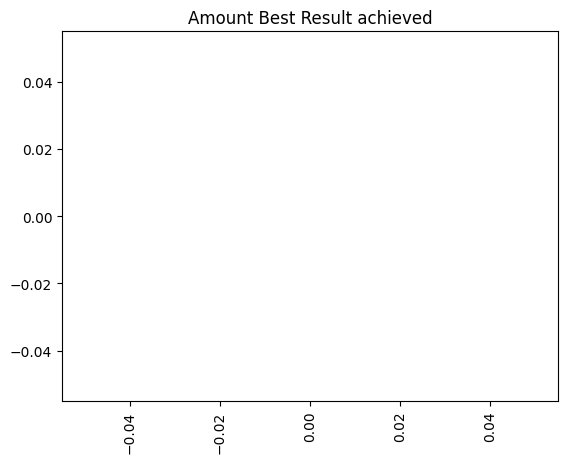

In [48]:
import matplotlib.pyplot as plt

plt.title('Amount Best Result achieved')
plt.bar([x[0] for x in comb_as_tuple if x[1] > 0 and x[0] != ''], [x[1] for x in comb_as_tuple if x[1] > 0 and x[0] != ''])
plt.xticks(rotation=90)
plt.show()

In [49]:
one_best_characteristics = dict()
some_best_characteristics = dict()
collected_best_characteristics = dict()
optimal_characteristics = dict()
for instance in optimal_solvers:
    for solver in optimal_solvers[instance]:
        if solver not in optimal_characteristics:
            optimal_characteristics[solver] = dict()
            optimal_characteristics[solver]['n_operations'] = []
            optimal_characteristics[solver]['flexibility'] = []
            optimal_characteristics[solver]['duration_variety'] = []
            optimal_characteristics[solver]['n_machines'] = []
            optimal_characteristics[solver]['d_average'] = []
        optimal_characteristics[solver]['n_operations'].append(benchmark_data[instance]['n_operations'])
        optimal_characteristics[solver]['flexibility'].append(benchmark_data[instance]['flexibility'])
        optimal_characteristics[solver]['duration_variety'].append(benchmark_data[instance]['duration_variety'])
        optimal_characteristics[solver]['n_machines'].append(benchmark_data[instance]['n_machines'])
        optimal_characteristics[solver]['d_average'].append(benchmark_data[instance]['additional_metrics']['d_average'])
for instance in instances_with_one_best:
    for solver in best_solvers[instance]:
        if solver not in one_best_characteristics:
            one_best_characteristics[solver] = dict()
            one_best_characteristics[solver]['n_operations'] = []
            one_best_characteristics[solver]['flexibility'] = []
            one_best_characteristics[solver]['duration_variety'] = []
            one_best_characteristics[solver]['n_machines'] = []
            one_best_characteristics[solver]['d_average'] = []
        if solver not in collected_best_characteristics:
            collected_best_characteristics[solver] = dict()
            collected_best_characteristics[solver]['n_operations'] = []
            collected_best_characteristics[solver]['flexibility'] = []
            collected_best_characteristics[solver]['duration_variety'] = []
            collected_best_characteristics[solver]['n_machines'] = []
            collected_best_characteristics[solver]['d_average'] = []
        one_best_characteristics[solver]['n_operations'].append(benchmark_data[instance]['n_operations'])
        one_best_characteristics[solver]['flexibility'].append(benchmark_data[instance]['flexibility'])
        one_best_characteristics[solver]['duration_variety'].append(benchmark_data[instance]['duration_variety'])
        one_best_characteristics[solver]['n_machines'].append(benchmark_data[instance]['n_machines'])
        one_best_characteristics[solver]['d_average'].append(benchmark_data[instance]['additional_metrics']['d_average'])
        collected_best_characteristics[solver]['n_operations'].append(benchmark_data[instance]['n_operations'])
        collected_best_characteristics[solver]['flexibility'].append(benchmark_data[instance]['flexibility'])
        collected_best_characteristics[solver]['duration_variety'].append(benchmark_data[instance]['duration_variety'])
        collected_best_characteristics[solver]['n_machines'].append(benchmark_data[instance]['n_machines'])
        collected_best_characteristics[solver]['d_average'].append(benchmark_data[instance]['additional_metrics']['d_average'])
for instance in instances_with_some_best:
    for solver in best_solvers[instance]:
        if solver not in some_best_characteristics:
            some_best_characteristics[solver] = dict()
            some_best_characteristics[solver]['n_operations'] = []
            some_best_characteristics[solver]['flexibility'] = []
            some_best_characteristics[solver]['duration_variety'] = []
            some_best_characteristics[solver]['n_machines'] = []
            some_best_characteristics[solver]['d_average'] = []
        if solver not in collected_best_characteristics:
            collected_best_characteristics[solver] = dict()
            collected_best_characteristics[solver]['n_operations'] = []
            collected_best_characteristics[solver]['flexibility'] = []
            collected_best_characteristics[solver]['duration_variety'] = []
            collected_best_characteristics[solver]['n_machines'] = []
            collected_best_characteristics[solver]['d_average'] = []
        some_best_characteristics[solver]['n_operations'].append(benchmark_data[instance]['n_operations'])
        some_best_characteristics[solver]['flexibility'].append(benchmark_data[instance]['flexibility'])
        some_best_characteristics[solver]['duration_variety'].append(benchmark_data[instance]['duration_variety'])
        some_best_characteristics[solver]['n_machines'].append(benchmark_data[instance]['n_machines'])
        some_best_characteristics[solver]['d_average'].append(benchmark_data[instance]['additional_metrics']['d_average'])
        collected_best_characteristics[solver]['n_operations'].append(benchmark_data[instance]['n_operations'])
        collected_best_characteristics[solver]['flexibility'].append(benchmark_data[instance]['flexibility'])
        collected_best_characteristics[solver]['duration_variety'].append(benchmark_data[instance]['duration_variety'])
        collected_best_characteristics[solver]['n_machines'].append(benchmark_data[instance]['n_machines'])
        collected_best_characteristics[solver]['d_average'].append(benchmark_data[instance]['additional_metrics']['d_average'])

In [50]:
import statistics
def get_stats(data, solver):
    result = dict()
    if solver in data:
        result['count'] = len(data[solver]['n_operations'])
        result['operations_mean'] = statistics.mean(data[solver]['n_operations'])
        result['operations_stdv'] = statistics.stdev(data[solver]['n_operations'])
        result['flexibility_mean'] = statistics.mean(data[solver]['flexibility'])
        result['flexibility_stdv'] = statistics.stdev(data[solver]['flexibility'])
        result['duration_variety_mean'] = statistics.mean(data[solver]['duration_variety'])
        result['duration_variety_stdv'] = statistics.stdev(data[solver]['duration_variety'])
        result['machines_mean'] = statistics.mean(data[solver]['n_machines'])
        result['machines_stdv'] = statistics.stdev(data[solver]['n_machines'])
        #result['machines_mean'] = statistics.mean(data[solver]['d_average'])
        #result['machines_stdv'] = statistics.stdev(data[solver]['d_average'])
    return result

stats_data = dict()
for solver in collected_best_characteristics.keys():
    if solver not in stats_data:
        stats_data[solver] = dict()
    if solver in one_best_characteristics:
        stats_data[solver]['one_best'] = get_stats(one_best_characteristics, solver)
    if solver in some_best_characteristics:
        stats_data[solver]['some_best'] = get_stats(some_best_characteristics, solver)
    if solver in collected_best_characteristics:
        stats_data[solver]['collected_best'] = get_stats(collected_best_characteristics, solver)
    if solver in optimal_characteristics:
        stats_data[solver]['optimal'] = get_stats(optimal_characteristics, solver)


In [51]:
def to_table_rows(data):
    table = ''
    for key in data:
        row = []
        if key == 'one_best':
            name = 'Single Best'
        elif key == 'some_best':
            name = 'Shared Best'
        elif key == 'optimal':
            name = 'Known Optimum'
        else:
            name = 'Combined'
        row.append(name)
        row.append('{:.1f}'.format(data[key]['count']))
        row.append('{:.4f}'.format(data[key]['machines_mean']))
        row.append('{:.4f}'.format(data[key]['machines_stdv']))
        row.append('{:.4f}'.format(data[key]['operations_mean']))
        row.append('{:.4f}'.format(data[key]['operations_stdv']))
        row.append('{:.4f}'.format(data[key]['flexibility_mean']))
        row.append('{:.4f}'.format(data[key]['flexibility_stdv']))
        row.append('{:.4f}'.format(data[key]['duration_variety_mean']))
        row.append('{:.4f}'.format(data[key]['duration_variety_stdv']))
        table += ' & '.join(row)[:-1] + '\\'
    return table

In [53]:
to_table_rows(stats_data['cplex_cp'])

KeyError: 'cplex_cp'

In [ ]:
to_table_rows(stats_data['ga_best'])

'Shared Best & 6.0 & 5.0000 & 0.0000 & 83.3333 & 12.9099 & 0.0122 & 0.0017 & 0.2817 & 0.034\\Combined & 6.0 & 5.0000 & 0.0000 & 83.3333 & 12.9099 & 0.0122 & 0.0017 & 0.2817 & 0.034\\Known Optimum & 8.0 & 5.1250 & 0.3536 & 73.2500 & 21.9464 & 0.0151 & 0.0060 & 0.2669 & 0.098\\'

In [ ]:
to_table_rows(stats_data['ortools'])

'Single Best & 15.0 & 7.4667 & 2.4456 & 78.0000 & 29.3331 & 0.0144 & 0.0048 & 0.3061 & 0.260\\Shared Best & 50.0 & 6.3000 & 3.0589 & 56.8800 & 40.5083 & 0.0426 & 0.0584 & 0.3674 & 0.295\\Combined & 65.0 & 6.5692 & 2.9526 & 61.7538 & 39.0509 & 0.0361 & 0.0525 & 0.3533 & 0.287\\Known Optimum & 48.0 & 5.6667 & 2.2345 & 47.3125 & 33.5788 & 0.0516 & 0.0607 & 0.3960 & 0.296\\'

In [ ]:
to_table_rows(stats_data['hexaly'])

'Single Best & 29.0 & 10.1034 & 1.9151 & 116.7586 & 52.2478 & 0.0099 & 0.0038 & 0.1424 & 0.153\\Shared Best & 36.0 & 6.3889 & 3.3405 & 58.5000 & 54.1899 & 0.0508 & 0.0667 & 0.3554 & 0.282\\Combined & 65.0 & 8.0462 & 3.3421 & 84.4923 & 60.4318 & 0.0325 & 0.0535 & 0.2603 & 0.255\\Known Optimum & 37.0 & 5.4324 & 2.1543 & 50.2703 & 54.4098 & 0.0599 & 0.0666 & 0.3984 & 0.289\\'

In [ ]:
to_table_rows(stats_data['cplex_lp'])

'Shared Best & 5.0 & 3.8000 & 2.4900 & 9.6000 & 4.9295 & 0.1267 & 0.0548 & 0.7244 & 0.174\\Combined & 5.0 & 3.8000 & 2.4900 & 9.6000 & 4.9295 & 0.1267 & 0.0548 & 0.7244 & 0.174\\Known Optimum & 11.0 & 4.1818 & 1.8340 & 15.7273 & 14.2133 & 0.0998 & 0.0527 & 0.6506 & 0.254\\'

In [ ]:
to_table_rows(stats_data['gurobi'])

'Shared Best & 7.0 & 6.5714 & 2.1492 & 30.0000 & 21.7025 & 0.0520 & 0.0357 & 0.2635 & 0.304\\Combined & 7.0 & 6.5714 & 2.1492 & 30.0000 & 21.7025 & 0.0520 & 0.0357 & 0.2635 & 0.304\\Known Optimum & 11.0 & 5.6364 & 2.2033 & 22.6364 & 19.6889 & 0.0710 & 0.0390 & 0.4486 & 0.350\\'

In [ ]:
solvers = list(collected_best_characteristics.keys())
solvers.remove('ga_average')

ValueError: list.remove(x): x not in list

: 

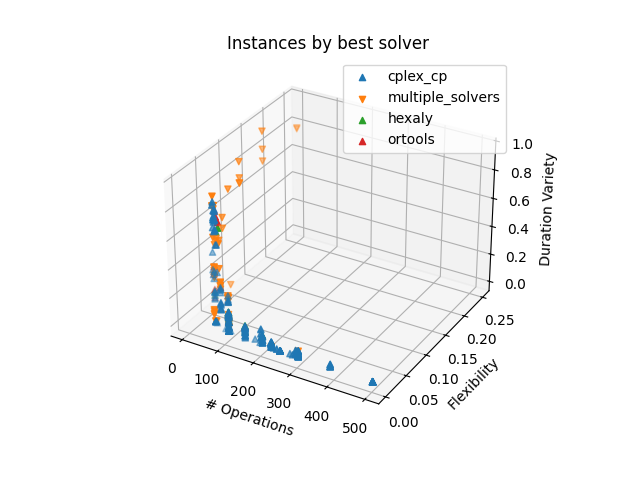

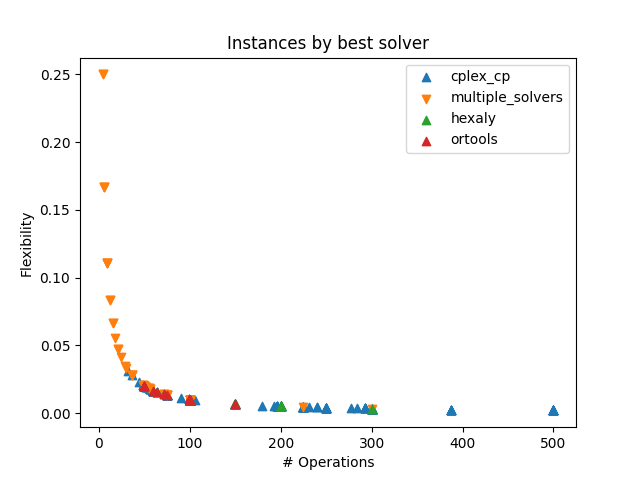

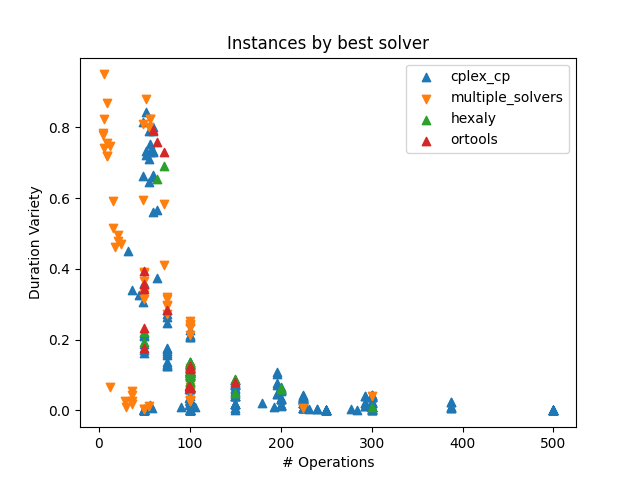

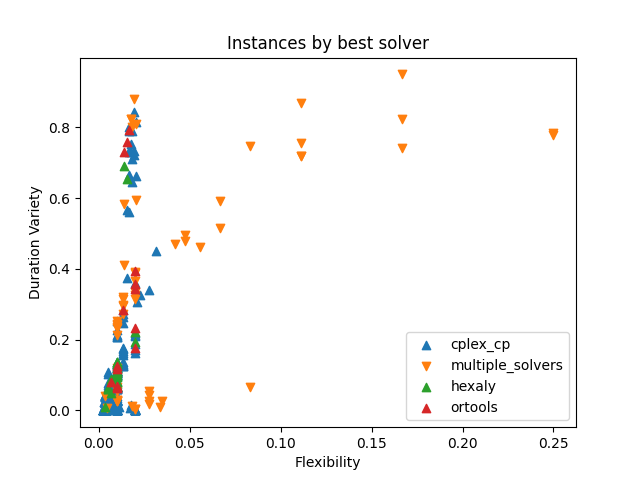

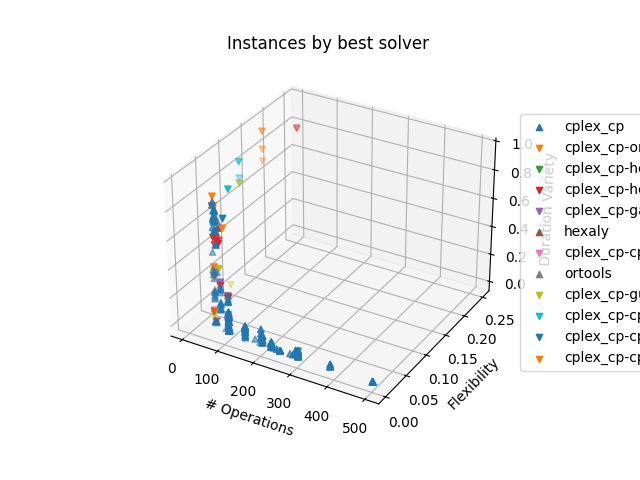

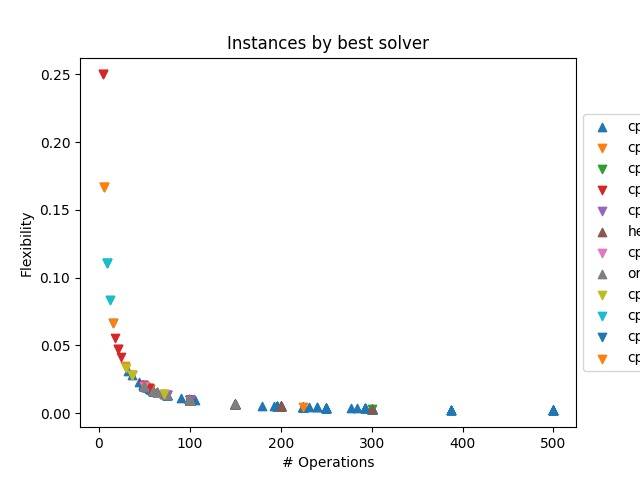

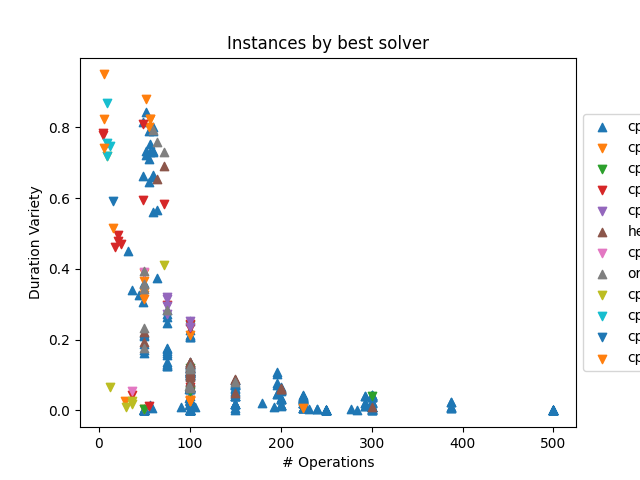

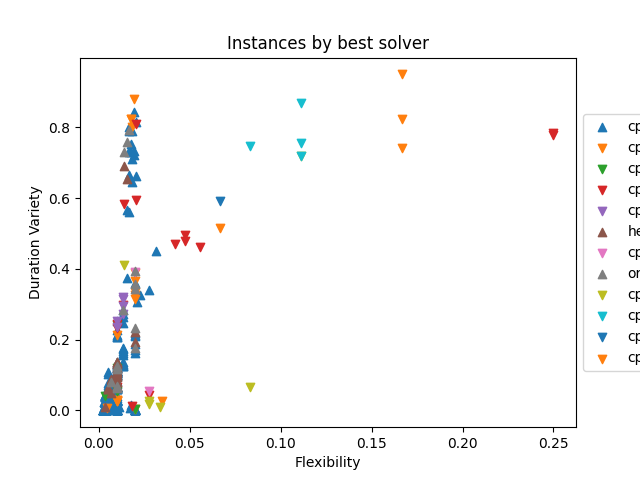

In [ ]:
%matplotlib widget 
import matplotlib.pyplot as plt
def scatter_3d_grouped(f, o , dv, labels, markers, xlabel, ylabel, zlabel, title):
    fig = plt.figure()
    ax = fig.add_subplot(projection='3d')
    one_solver = dict()
    for i in range(len(f)):
        if markers[i] == '^':
            if labels[i] not in one_solver:
                one_solver[labels[i]] = []
            one_solver[labels[i]].append([f[i], o[i], dv[i], '^', 'r'])
        elif markers[i] == 'v':
            if 'multiple_solvers' not in one_solver:
                one_solver['multiple_solvers'] = []
            one_solver['multiple_solvers'].append([f[i], o[i], dv[i], 'v', 'g'])
        else:
            if 'all' not in one_solver:
                one_solver['all'] = []
            one_solver['all'].append([f[i], o[i], dv[i], '.', 'b'])
    for solver in one_solver:
        ax.scatter([x[0] for x in one_solver[solver]], [x[1] for x in one_solver[solver]], [x[2] for x in one_solver[solver]], label=solver, marker=one_solver[solver][0][3])
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.set_zlabel(zlabel)
    ax.set_title(title)
    ax.legend()
    plt.show()

def scatter_2d_grouped(x, y, labels, markers, xlabel, ylabel, title):
    fig = plt.figure()
    ax = fig.add_subplot()
    one_solver = dict()
    for i in range(len(x)):
        if markers[i] == '^':
            if labels[i] not in one_solver:
                one_solver[labels[i]] = []
            one_solver[labels[i]].append([x[i], y[i], '^', 'r'])
        elif markers[i] == 'v':
            if 'multiple_solvers' not in one_solver:
                one_solver['multiple_solvers'] = []
            one_solver['multiple_solvers'].append([x[i], y[i], 'v', 'g'])
        else:
            if 'all' not in one_solver:
                one_solver['all'] = []
            one_solver['all'].append([x[i], y[i], '.', 'b'])
    for solver in one_solver:
        ax.scatter([x[0] for x in one_solver[solver]], [x[1] for x in one_solver[solver]], label=solver, marker=one_solver[solver][0][2])
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.set_title(title)
    ax.legend()
    plt.show()

def scatter_3d(f, o , dv, labels, markers, xlabel, ylabel, zlabel, title):
    fig = plt.figure()
    ax = fig.add_subplot(projection='3d')
    one_solver = dict()
    for i in range(len(f)):
        if labels[i] not in one_solver:
            one_solver[labels[i]] = []
        one_solver[labels[i]].append([f[i], o[i], dv[i], markers[i]])

    for solver in one_solver:
        ax.scatter([x[0] for x in one_solver[solver]], [x[1] for x in one_solver[solver]], [x[2] for x in one_solver[solver]], label=solver, marker=one_solver[solver][0][3])
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.set_zlabel(zlabel)
    ax.set_title(title)
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.show()

def scatter_2d(x, y, labels, markers, xlabel, ylabel, title):
    fig = plt.figure()
    ax = fig.add_subplot()
    one_solver = dict()
    for i in range(len(x)):
        if labels[i] not in one_solver:
            one_solver[labels[i]] = []
        one_solver[labels[i]].append([x[i], y[i], markers[i]])
        
    for solver in one_solver:
        ax.scatter([x[0] for x in one_solver[solver]], [x[1] for x in one_solver[solver]], label=solver, marker=one_solver[solver][0][2])
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.set_title(title)
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.show()

plot_data = []
labels = []
markers = []
marker_names = {'.': 'all', '^': 'one best', 'v': 'multiple best'}
for benchmark in benchmark_data:
    plot_data.append([benchmark_data[benchmark]['n_operations'], benchmark_data[benchmark]['flexibility'], benchmark_data[benchmark]['duration_variety']])
    n_solvers = len(best_solvers[benchmark])
    if 'ga_average' in best_solvers[benchmark]:
        n_solvers -= 1
    all_solved = n_solvers == len(solvers)
    marker = '.' if all_solved else '^' if n_solvers == 1 else 'v'
    label = 'all' if all_solved else '-'.join(best_solvers[benchmark])
    markers.append(marker)
    labels.append(label)

scatter_3d_grouped([x[0] for x in plot_data], [x[1] for x in plot_data], [x[2] for x in plot_data], labels, markers, '# Operations', 'Flexibility', 'Duration Variety', 'Instances by best solver')
scatter_2d_grouped([x[0] for x in plot_data], [x[1] for x in plot_data], labels, markers, '# Operations', 'Flexibility', 'Instances by best solver')
scatter_2d_grouped([x[0] for x in plot_data], [x[2] for x in plot_data], labels, markers, '# Operations', 'Duration Variety', 'Instances by best solver')
scatter_2d_grouped([x[1] for x in plot_data], [x[2] for x in plot_data], labels, markers, 'Flexibility', 'Duration Variety', 'Instances by best solver')

scatter_3d([x[0] for x in plot_data], [x[1] for x in plot_data], [x[2] for x in plot_data], labels, markers, '# Operations', 'Flexibility', 'Duration Variety', 'Instances by best solver')
scatter_2d([x[0] for x in plot_data], [x[1] for x in plot_data], labels, markers, '# Operations', 'Flexibility', 'Instances by best solver')
scatter_2d([x[0] for x in plot_data], [x[2] for x in plot_data], labels, markers, '# Operations', 'Duration Variety', 'Instances by best solver')
scatter_2d([x[1] for x in plot_data], [x[2] for x in plot_data], labels, markers, 'Flexibility', 'Duration Variety', 'Instances by best solver')

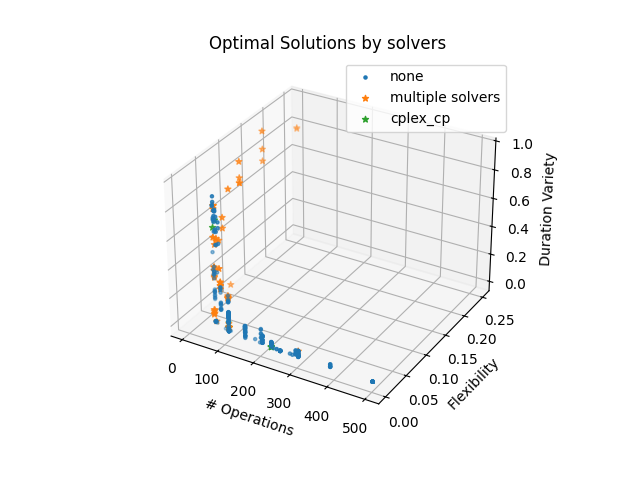

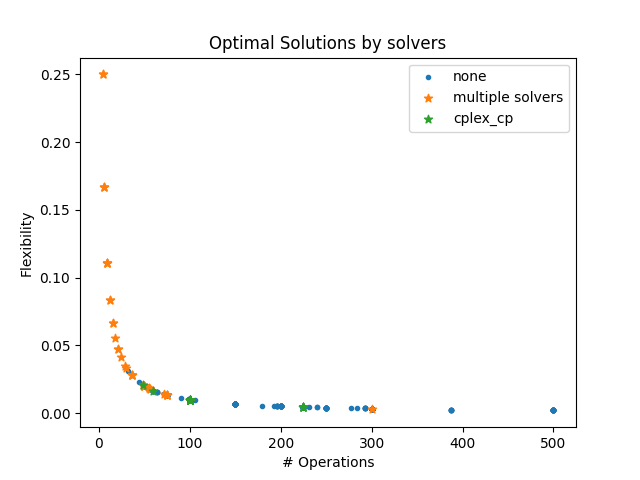

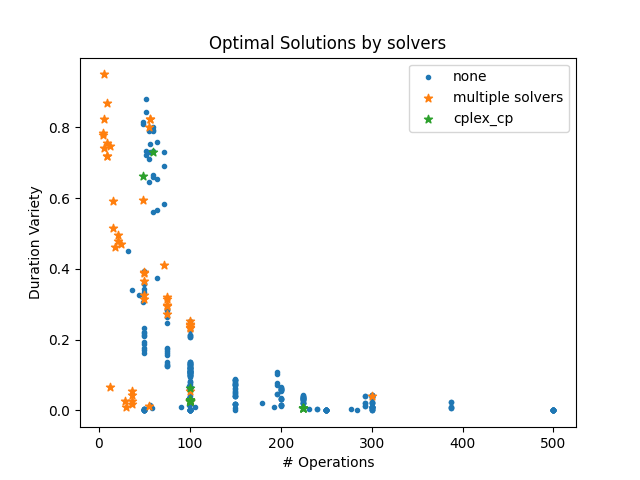

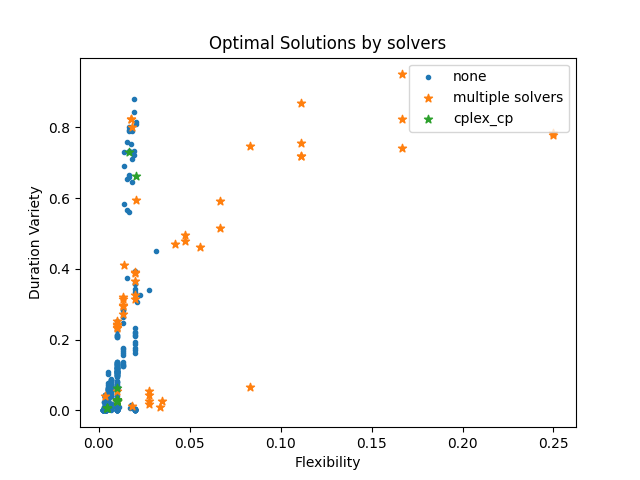

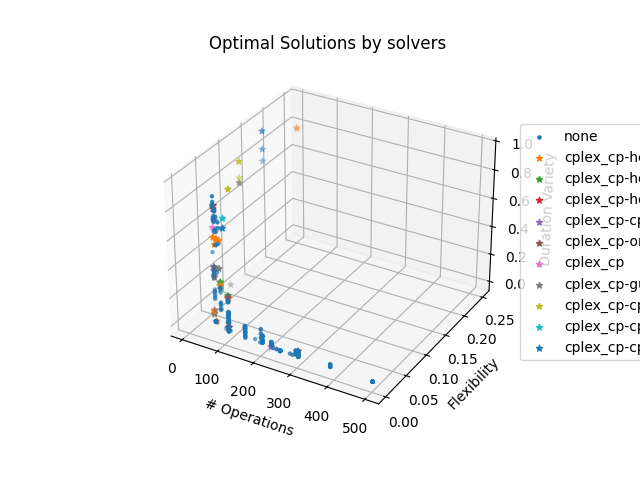

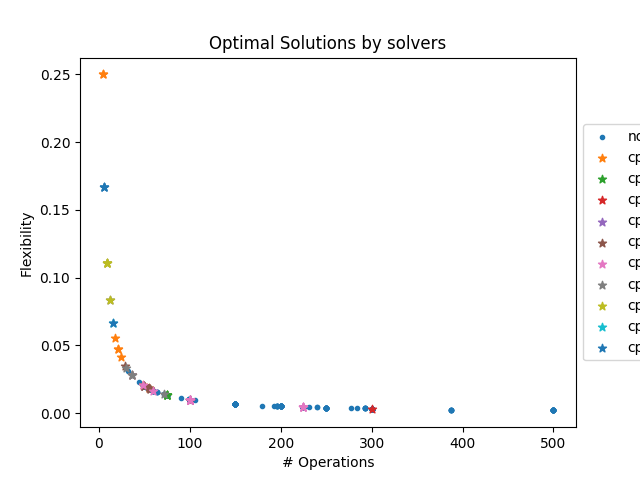

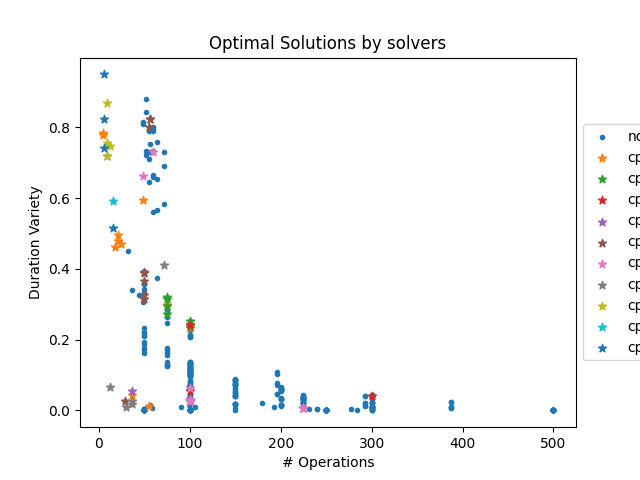

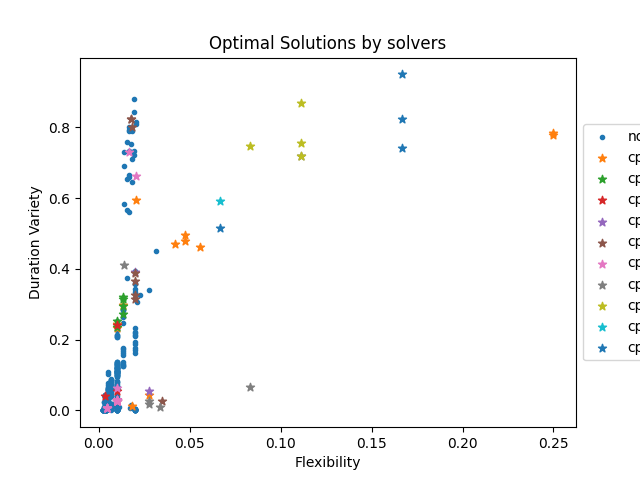

In [ ]:
%matplotlib widget 
import matplotlib.pyplot as plt
def scatter_3d_grouped(f, o , dv, labels, markers, xlabel, ylabel, zlabel, title):
    fig = plt.figure()
    ax = fig.add_subplot(projection='3d')
    one_solver = dict()
    for i in range(len(f)):
        if markers[i] == '*':
            if '-' in labels[i]:
                if 'multiple solvers' not in one_solver:
                    one_solver['multiple solvers'] = []
                one_solver['multiple solvers'].append([f[i], o[i], dv[i], markers[i]])
            else:
                if labels[i] not in one_solver:
                    one_solver[labels[i]] = []
                one_solver[labels[i]].append([f[i], o[i], dv[i], markers[i], 'r'])
        else:
            if 'none' not in one_solver:
                one_solver['none'] = []
            one_solver['none'].append([f[i], o[i], dv[i], '.', 'b'])
    for solver in one_solver:
        ax.scatter([x[0] for x in one_solver[solver]], [x[1] for x in one_solver[solver]], [x[2] for x in one_solver[solver]], label=solver, marker=one_solver[solver][0][3])
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.set_zlabel(zlabel)
    ax.set_title(title)
    ax.legend()
    plt.show()

def scatter_2d_grouped(x, y, labels, markers, xlabel, ylabel, title):
    fig = plt.figure()
    ax = fig.add_subplot()
    one_solver = dict()
    for i in range(len(x)):
        if markers[i] == '*':
            if '-' in labels[i]:
                if 'multiple solvers' not in one_solver:
                    one_solver['multiple solvers'] = []
                one_solver['multiple solvers'].append([x[i], y[i], markers[i]])
            else:
                if labels[i] not in one_solver:
                    one_solver[labels[i]] = []
                one_solver[labels[i]].append([x[i], y[i], markers[i], 'r'])
        else:
            if 'none' not in one_solver:
                one_solver['none'] = []
            one_solver['none'].append([x[i], y[i], '.', 'b'])
    for solver in one_solver:
        ax.scatter([x[0] for x in one_solver[solver]], [x[1] for x in one_solver[solver]], label=solver, marker=one_solver[solver][0][2])
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.set_title(title)
    ax.legend()
    plt.show()

def scatter_3d(f, o , dv, labels, markers, xlabel, ylabel, zlabel, title):
    fig = plt.figure()
    ax = fig.add_subplot(projection='3d')
    one_solver = dict()
    for i in range(len(f)):
        if labels[i] not in one_solver:
            one_solver[labels[i]] = []
        one_solver[labels[i]].append([f[i], o[i], dv[i], markers[i], 'r'])
    for solver in one_solver:
        ax.scatter([x[0] for x in one_solver[solver]], [x[1] for x in one_solver[solver]], [x[2] for x in one_solver[solver]], label=solver, marker=one_solver[solver][0][3])
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.set_zlabel(zlabel)
    ax.set_title(title)
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.show()

def scatter_2d(x, y, labels, markers, xlabel, ylabel, title):
    fig = plt.figure()
    ax = fig.add_subplot()
    one_solver = dict()
    for i in range(len(x)):
        if labels[i] not in one_solver:
            one_solver[labels[i]] = []
        one_solver[labels[i]].append([x[i], y[i], markers[i], 'r'])
    for solver in one_solver:
        ax.scatter([x[0] for x in one_solver[solver]], [x[1] for x in one_solver[solver]], label=solver, marker=one_solver[solver][0][2])
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.set_title(title)
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.show()

plot_data = []
labels = []
markers = []
colors =  []
for benchmark in benchmark_data:
    marker = '.'
    label = 'none'
    n_solvers = len(optimal_solvers[benchmark])
    if 'ga_average' in best_solvers[benchmark]:
        n_solvers -= 1
    all_solved = n_solvers == len(solvers)
    plot_data.append([benchmark_data[benchmark]['n_operations'], benchmark_data[benchmark]['flexibility'], benchmark_data[benchmark]['duration_variety']])
    if benchmark in optimal_solvers and len(optimal_solvers[benchmark]) > 0:
        marker = '*'# if len(optimal_solvers[benchmark]) == 1 else 'x'
        color = 'r' if len(optimal_solvers[benchmark]) == 1 else 'g'
        label = 'all' if all_solved else '-'.join(optimal_solvers[benchmark])#optimal_solvers[benchmark][0] if len(optimal_solvers[benchmark]) == 1 else 'multiple solvers' if benchmark in instances_with_some_best else 'all'
    markers.append(marker)
    labels.append(label)
ops = [x[0] for x in plot_data]
flex = [x[1] for x in plot_data]
dvs = [x[2] for x in plot_data]
scatter_3d_grouped(ops, flex, dvs, labels, markers, '# Operations', 'Flexibility', 'Duration Variety', 'Optimal Solutions by solvers')
scatter_2d_grouped(ops, flex, labels, markers, '# Operations', 'Flexibility', 'Optimal Solutions by solvers')
scatter_2d_grouped(ops, dvs, labels, markers, '# Operations', 'Duration Variety', 'Optimal Solutions by solvers')
scatter_2d_grouped(flex, dvs, labels, markers, 'Flexibility', 'Duration Variety', 'Optimal Solutions by solvers')

scatter_3d(ops, flex, dvs, labels, markers, '# Operations', 'Flexibility', 'Duration Variety', 'Optimal Solutions by solvers')
scatter_2d(ops, flex, labels, markers, '# Operations', 'Flexibility', 'Optimal Solutions by solvers')
scatter_2d(ops, dvs, labels, markers, '# Operations', 'Duration Variety', 'Optimal Solutions by solvers')
scatter_2d(flex, dvs, labels, markers, 'Flexibility', 'Duration Variety', 'Optimal Solutions by solvers')

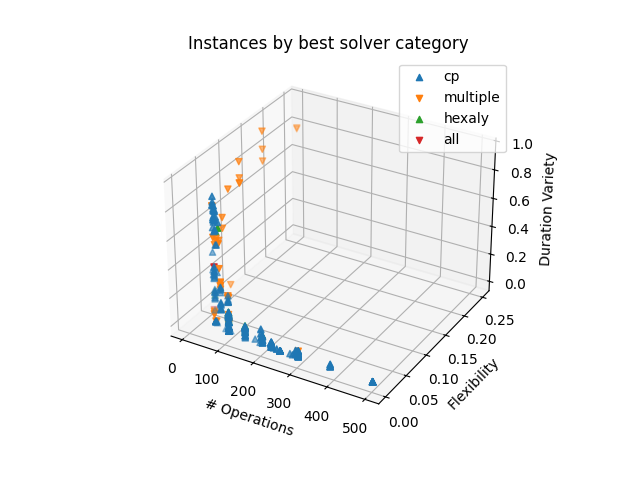

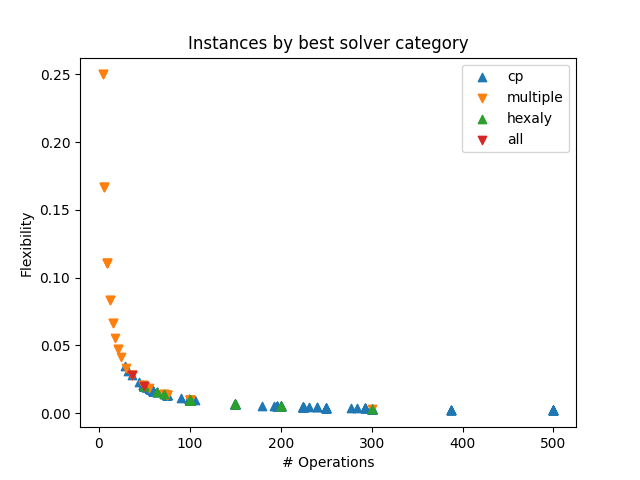

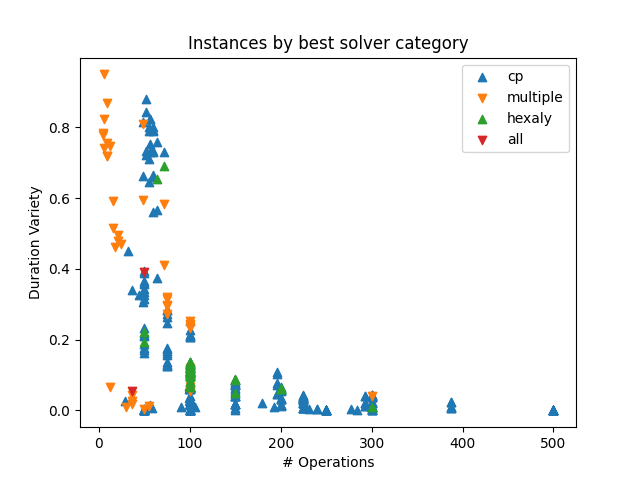

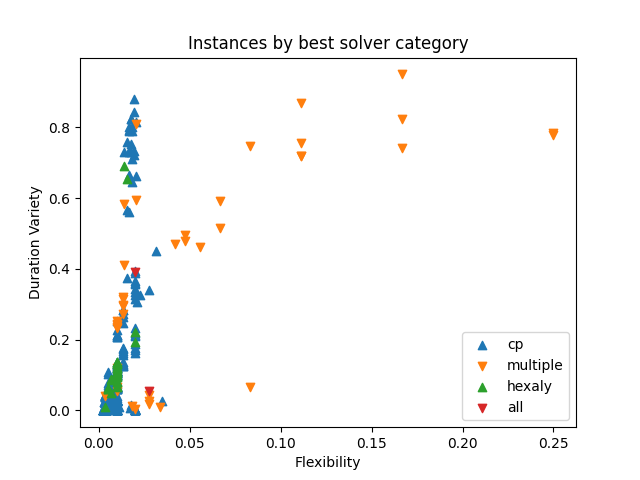

{'cp': 330, 'multiple': 41, 'hexaly': 29, 'all': 2}


In [ ]:
%matplotlib widget 
import matplotlib.pyplot as plt

def scatter_3d(f, o , dv, labels, markers, xlabel, ylabel, zlabel, title):
    fig = plt.figure()
    ax = fig.add_subplot(projection='3d')
    one_solver = dict()
    for i in range(len(f)):
        if labels[i] not in one_solver:
            one_solver[labels[i]] = []
        one_solver[labels[i]].append([f[i], o[i], dv[i], markers[i]])

    for solver in one_solver:
        ax.scatter([x[0] for x in one_solver[solver]], [x[1] for x in one_solver[solver]], [x[2] for x in one_solver[solver]], label=solver, marker=one_solver[solver][0][3])
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.set_zlabel(zlabel)
    ax.set_title(title)
    if GROUPED:
        ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    else:
        ax.legend()
    plt.show()

def scatter_2d(x, y, labels, markers, xlabel, ylabel, title):
    fig = plt.figure()
    ax = fig.add_subplot()
    one_solver = dict()
    for i in range(len(x)):
        if labels[i] not in one_solver:
            one_solver[labels[i]] = []
        one_solver[labels[i]].append([x[i], y[i], markers[i]])
        
    for solver in one_solver:
        ax.scatter([x[0] for x in one_solver[solver]], [x[1] for x in one_solver[solver]], label=solver, marker=one_solver[solver][0][2])
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.set_title(title)
    if GROUPED:
        ax.legend()
    else:
        ax.legend()
    plt.show()

def is_milp(instance):
    return (len(best_solvers[instance]) == 2 and 'gurobi' in best_solvers[instance] and 'cplex_lp' in best_solvers[instance]) or (len(best_solvers) == 1 and 'gurobi' in best_solvers) or (len(best_solvers) == 1 and 'cplex_lp' in best_solvers)

def is_cp(instance):
    return len(best_solvers[instance]) == 2 and 'cplex_cp' in best_solvers[instance] and 'ortools' in best_solvers[instance] or (len(best_solvers) == 1 and 'cplex_cp' in best_solvers) or (len(best_solvers) == 1 and 'ortools' in best_solvers)

def is_ga(instance):
    return len(best_solvers[instance]) == 1 and 'ga_best' in best_solvers[instance] or (len(best_solvers[instance]) == 2 and 'ga_average' in best_solvers[instance] and 'ga_best' in best_solvers[instance])

def is_hexaly(instance):
    return len(best_solvers[instance]) == 1 and 'hexaly' in best_solvers[instance]

def get_group(instance):
    groups = []
    """if is_milp(instance):
        groups.append('milp')
    if is_cp(instance):
        groups.append('cp')
    if is_hexaly(instance):
        groups.append('hexaly')
    if is_ga(instance):
        groups.append('ga')
    if len(groups) == 0:
        groups.append('multiple')
    elif len(groups) == 4:
        return 'all'"""
    if 'gurobi' in best_solvers[instance] or 'cplex_lp' in best_solvers[instance]:
        groups.append('milp')
    if 'ortools' in best_solvers[instance] or 'cplex_cp' in best_solvers[instance]:
        groups.append('cp')
    if 'hexaly' in best_solvers[instance]:
        groups.append('hexaly')
    if 'ga_best' in best_solvers[instance] or 'ga_average' in best_solvers[instance]:
        groups.append('ga')
    if len(groups) == 4:
        return 'all'
    if len(groups) > 1:
        return 'multiple'
    return groups[0]

def get_multi_groups(instance):
    groups = []
    if 'gurobi' in best_solvers[instance] or 'cplex_lp' in best_solvers[instance]:
        groups.append('milp')
    if 'ortools' in best_solvers[instance] or 'cplex_cp' in best_solvers[instance]:
        groups.append('cp')
    if 'hexaly' in best_solvers[instance]:
        groups.append('hexaly')
    if 'ga_best' in best_solvers[instance] or 'ga_average' in best_solvers[instance]:
        groups.append('ga')
    return groups

GROUPED = False
plot_data = []
labels = []
markers = []
marker_names = {'.': 'all', '^': 'one best', 'v': 'multiple best'}
counts = dict()
for benchmark in benchmark_data:
    plot_data.append([benchmark_data[benchmark]['n_operations'], benchmark_data[benchmark]['flexibility'], benchmark_data[benchmark]['duration_variety']])
    n_solvers = len(best_solvers[benchmark])
    if 'ga_average' in best_solvers[benchmark]:
        n_solvers -= 1
    all_solved = n_solvers >= len(solvers)
    marker = '.' if all_solved else '^' if n_solvers == 1 else 'v'
    if GROUPED:
        groups = get_multi_groups(benchmark)
        label = '-'.join(groups) if len(groups) < 4 else 'all'
    else:
        label = get_group(benchmark) # for simple grouped
    if label not in counts:
        counts[label] = 0    
    counts[label] += 1
    markers.append(marker)
    labels.append(label)

scatter_3d([x[0] for x in plot_data], [x[1] for x in plot_data], [x[2] for x in plot_data], labels, markers, '# Operations', 'Flexibility', 'Duration Variety', 'Instances by best solver category')
scatter_2d([x[0] for x in plot_data], [x[1] for x in plot_data], labels, markers, '# Operations', 'Flexibility', 'Instances by best solver category')
scatter_2d([x[0] for x in plot_data], [x[2] for x in plot_data], labels, markers, '# Operations', 'Duration Variety', 'Instances by best solver category')
scatter_2d([x[1] for x in plot_data], [x[2] for x in plot_data], labels, markers, 'Flexibility', 'Duration Variety', 'Instances by best solver category')
print(counts)

In [ ]:
counts = dict()
for instance in best_solvers:
    best : list = best_solvers[instance]
    if 'ga_average' in best:
        best.remove('ga_average')
    if 'ga_best' in best:
        best[best.index('ga_best')] = 'ga'
    name = '-'.join(best)
    if name not in counts:
        counts[name] = 0
    counts[name] += 1


In [ ]:
for count in counts:
    print(f'{count}: {counts[count]}')

cplex_cp: 297
cplex_cp-ortools: 18
cplex_cp-hexaly: 5
cplex_cp-hexaly-ortools: 15
cplex_cp-ga-hexaly-ortools: 6
hexaly: 29
cplex_cp-cplex_lp-ga-hexaly-ortools: 2
ortools: 15
cplex_cp-gurobi-hexaly-ortools: 6
cplex_cp-cplex_lp-gurobi-hexaly-ortools: 4
cplex_cp-cplex_lp-gurobi-ortools: 1
cplex_cp-cplex_lp-hexaly-ortools: 4


In [ ]:
names = list(counts.keys())
names.sort(key=lambda x: len(x))
#print(names)
for name in names:
    print(f'{name}: {counts[name]}')

hexaly: 29
ortools: 15
cplex_cp: 297
cplex_cp-hexaly: 5
cplex_cp-ortools: 18
cplex_cp-hexaly-ortools: 15
cplex_cp-ga-hexaly-ortools: 6
cplex_cp-gurobi-hexaly-ortools: 6
cplex_cp-cplex_lp-gurobi-ortools: 1
cplex_cp-cplex_lp-hexaly-ortools: 4
cplex_cp-cplex_lp-ga-hexaly-ortools: 2
cplex_cp-cplex_lp-gurobi-hexaly-ortools: 4


In [ ]:
def get_mean_std(data):
    return {'mean': statistics.mean(data), 'stdev': statistics.stdev(data), 'max': max(data), 'min': min(data)}

count = len(benchmark_data)
flexibility = []
duration_variety = []
n_operations = []
n_machines = []
for benchmark in benchmark_data:
    instance = benchmark_data[benchmark]
    flexibility.append(instance['flexibility'])
    duration_variety.append(instance['duration_variety'])
    n_operations.append(instance['n_operations'])
    n_machines.append(instance['n_machines'])
flex = get_mean_std(flexibility)
dv = get_mean_std(duration_variety)
op = get_mean_std(n_operations)
ma = get_mean_std(n_machines)
print(flex)
print(dv)
print(op)
print(ma)

{'mean': 0.01421645976541996, 'stdev': 0.025484162762254414, 'max': 0.25, 'min': 0.002}
{'mean': 0.14964255090141335, 'stdev': 0.22412826718150225, 'max': 0.95, 'min': 5.666916766593299e-05}
{'mean': 150.1144278606965, 'stdev': 111.25729807459317, 'max': 500, 'min': 4}
{'mean': 13.512437810945274, 'stdev': 13.16672654108999, 'max': 60, 'min': 2}


In [ ]:
flexibility.sort()
duration_variety.sort()
n_operations.sort()
n_machines.sort()

In [ ]:
def get_stats(data, solver):
    result = dict()
    if solver in data:
        result['count'] = len(data[solver]['n_operations'])
        result['operations_mean'] = statistics.mean(data[solver]['n_operations'])
        result['operations_max'] = max(data[solver]['n_operations'])
        result['operations_min'] = min(data[solver]['n_operations'])
        result['operations_stdv'] = statistics.stdev(data[solver]['n_operations'])
        result['flexibility_mean'] = statistics.mean(data[solver]['flexibility'])
        result['flexibility_max'] = max(data[solver]['flexibility'])
        result['flexibility_min'] = min(data[solver]['flexibility'])
        result['flexibility_stdv'] = statistics.stdev(data[solver]['flexibility'])
        result['duration_variety_mean'] = statistics.mean(data[solver]['duration_variety'])
        result['duration_variety_max'] = max(data[solver]['duration_variety'])
        result['duration_variety_min'] = min(data[solver]['duration_variety'])
        result['duration_variety_stdv'] = statistics.stdev(data[solver]['duration_variety'])
        result['machines_mean'] = statistics.mean(data[solver]['n_machines'])
        result['machines_max'] = max(data[solver]['n_machines'])
        result['machines_min'] = min(data[solver]['n_machines'])
        result['machines_stdv'] = statistics.stdev(data[solver]['n_machines'])
    return result

stats_data = dict()
for solver in collected_best_characteristics.keys():
    if solver not in stats_data:
        stats_data[solver] = dict()
    if solver in one_best_characteristics:
        stats_data[solver]['one_best'] = get_stats(one_best_characteristics, solver)
    if solver in some_best_characteristics:
        stats_data[solver]['some_best'] = get_stats(some_best_characteristics, solver)
    if solver in collected_best_characteristics:
        stats_data[solver]['collected_best'] = get_stats(collected_best_characteristics, solver)

C:\Users\huda\AppData\Local\Temp\ipykernel_20904\380385891.py:1: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig = plt.figure(layout='tight', figsize=(15, 10))


Text(0.5, 0.98, 'Average Benchmark Characteristics for all solvers (best solutions)')

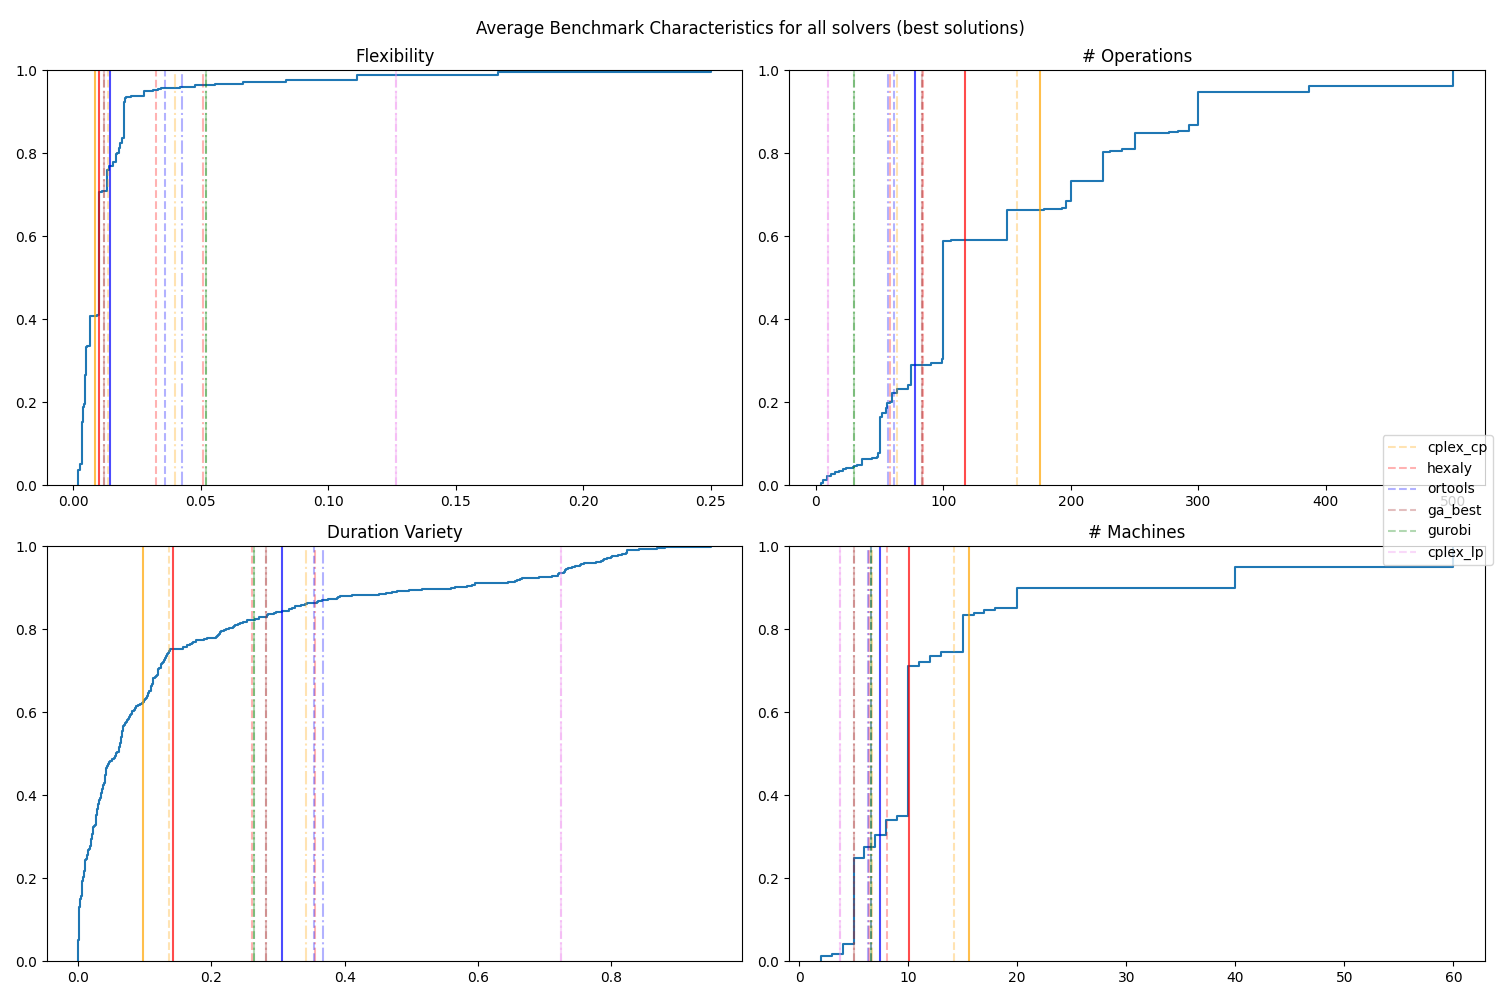

In [ ]:
fig = plt.figure(layout='tight', figsize=(15, 10))
solver_colors = {'ortools': 'blue', 'hexaly': 'red', 'cplex_cp': 'orange', 'ga_average': 'pink', 'ga_best': 'brown', 'gurobi': 'green', 'cplex_lp': 'violet'}
solver_labels = {'ortools': 'ORTOOLS', 'hexaly': 'HEXALY', 'cplex_cp': 'CPLEX-CP', 'ga_average': 'GA', 'ga_best': 'GA Average', 'gurobi': 'GUROBI', 'cplex_lp': 'CPLEX-LP'}
axs = fig.subplots(2, 2)
lines = []
labels = []
axs[0][0].ecdf(flexibility)
axs[0][0].set_title('Flexibility')
for solver in stats_data:
    lines.append(axs[0][0].vlines([stats_data[solver]['collected_best']['flexibility_mean']], 0.0, 1.0, label=solver_labels[solver], color=solver_colors[solver], alpha=0.3, linestyles='dashed'))
    labels.append(solver)
    if 'one_best' in stats_data[solver]:
        axs[0][0].vlines([stats_data[solver]['one_best']['flexibility_mean']], 0.0, 1.0, label=solver_labels[solver], color=solver_colors[solver], alpha=0.7, linestyles='solid')
    axs[0][0].vlines([stats_data[solver]['some_best']['flexibility_mean']], 0.0, 1.0, label=solver_labels[solver], color=solver_colors[solver], alpha=0.3, linestyles='dashdot')

axs[1][0].ecdf(duration_variety)
axs[1][0].set_title('Duration Variety')
for solver in stats_data:
    axs[1][0].vlines([stats_data[solver]['collected_best']['duration_variety_mean']], 0.0, 1.0, label=solver_labels[solver], color=solver_colors[solver], alpha=0.3, linestyles='dashed')
    if 'one_best' in stats_data[solver]:
        axs[1][0].vlines([stats_data[solver]['one_best']['duration_variety_mean']], 0.0, 1.0, label=solver_labels[solver], color=solver_colors[solver], alpha=0.7, linestyles='solid')
    axs[1][0].vlines([stats_data[solver]['some_best']['duration_variety_mean']], 0.0, 1.0, label=solver_labels[solver], color=solver_colors[solver], alpha=0.3, linestyles='dashdot')
axs[0][1].ecdf(n_operations)
axs[0][1].set_title('# Operations')
for solver in stats_data:
    axs[0][1].vlines([stats_data[solver]['collected_best']['operations_mean']], 0.0, 1.0, label=solver_labels[solver], color=solver_colors[solver], alpha=0.3, linestyles='dashed')
    if 'one_best' in stats_data[solver]:
        axs[0][1].vlines([stats_data[solver]['one_best']['operations_mean']], 0.0, 1.0, label=solver_labels[solver], color=solver_colors[solver], alpha=0.7, linestyles='solid')
    axs[0][1].vlines([stats_data[solver]['some_best']['operations_mean']], 0.0, 1.0, label=solver_labels[solver], color=solver_colors[solver], alpha=0.3, linestyles='dashdot')
axs[1][1].ecdf(n_machines)
axs[1][1].set_title('# Machines')
for solver in stats_data:
    axs[1][1].vlines([stats_data[solver]['collected_best']['machines_mean']], 0.0, 1.0, label=solver_labels[solver], color=solver_colors[solver], alpha=0.3, linestyles='dashed')
    if 'one_best' in stats_data[solver]:
        axs[1][1].vlines([stats_data[solver]['one_best']['machines_mean']], 0.0, 1.0, label=solver_labels[solver], color=solver_colors[solver], alpha=0.7, linestyles='solid')
    axs[1][1].vlines([stats_data[solver]['some_best']['machines_mean']], 0.0, 1.0, label=solver_labels[solver], color=solver_colors[solver], alpha=0.3, linestyles='dashdot')
fig.legend(loc='center right', handles=lines, labels=labels)
fig.suptitle('Average Benchmark Characteristics for all solvers (best solutions)')

Text(0.5, 0.98, 'Average Benchmark Characteristics for all solvers (all best solutions)')

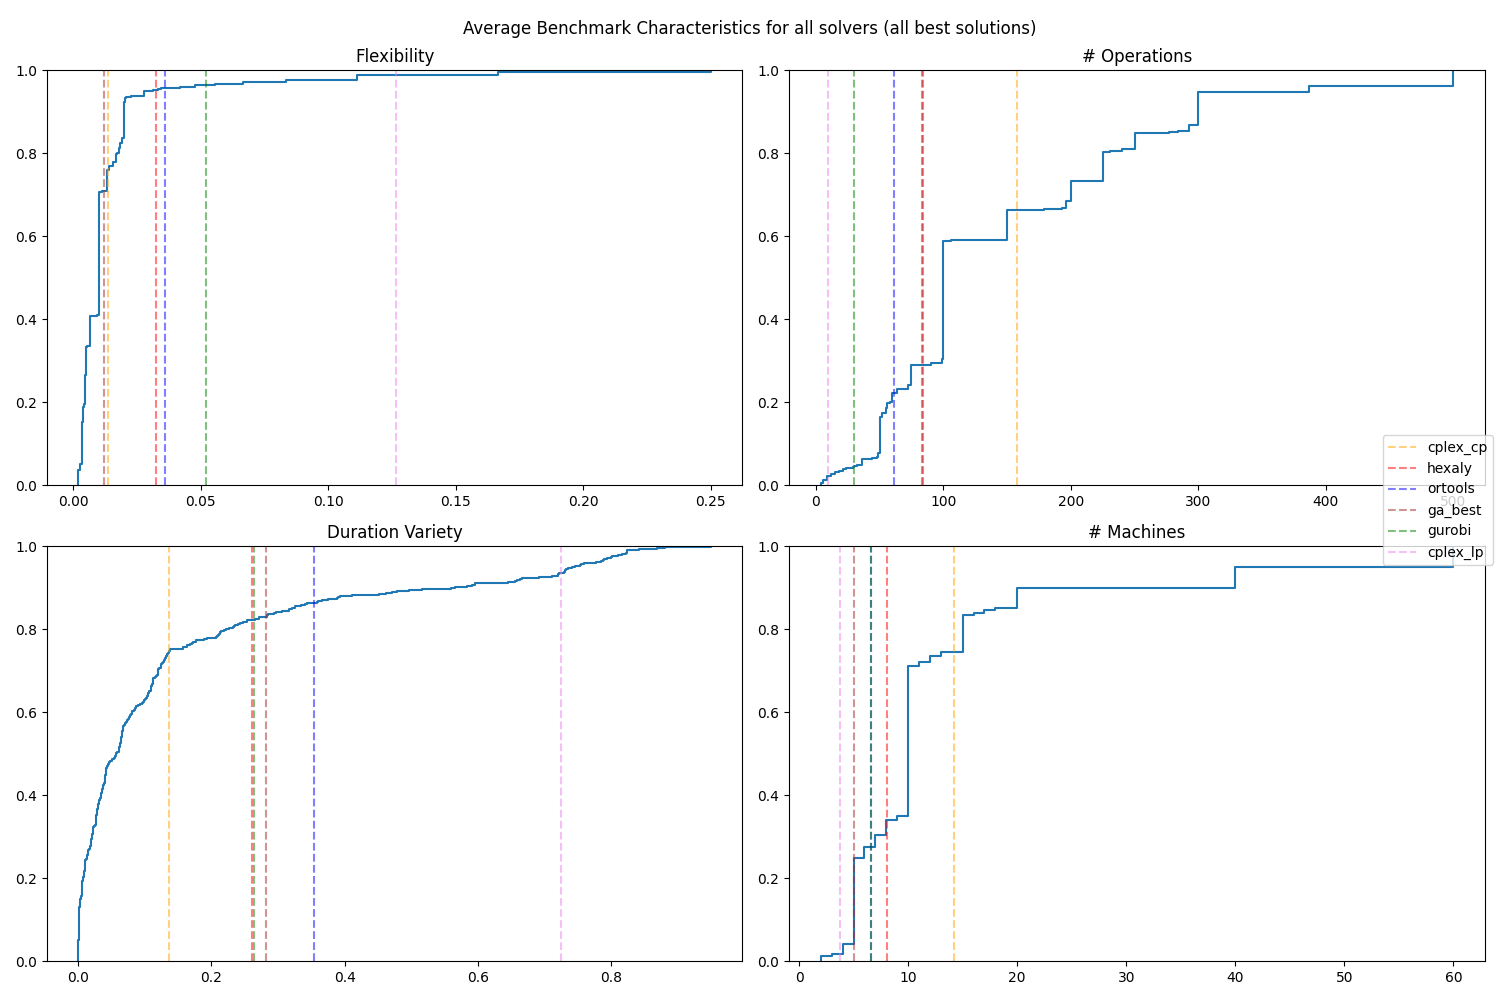

In [ ]:
fig = plt.figure(layout='tight', figsize=(15, 10))
solver_colors = {'ortools': 'blue', 'hexaly': 'red', 'cplex_cp': 'orange', 'ga_average': 'pink', 'ga_best': 'brown', 'gurobi': 'green', 'cplex_lp': 'violet'}
solver_labels = {'ortools': 'ORTOOLS', 'hexaly': 'HEXALY', 'cplex_cp': 'CPLEX-CP', 'ga_average': 'GA', 'ga_best': 'GA Average', 'gurobi': 'GUROBI', 'cplex_lp': 'CPLEX-LP'}
axs = fig.subplots(2, 2)
lines = []
labels = []
axs[0][0].ecdf(flexibility)
axs[0][0].set_title('Flexibility')
for solver in stats_data:
    lines.append(axs[0][0].vlines([stats_data[solver]['collected_best']['flexibility_mean']], 0.0, 1.0, label=solver_labels[solver], color=solver_colors[solver], alpha=0.5, linestyles='dashed'))
    labels.append(solver)

axs[1][0].ecdf(duration_variety)
axs[1][0].set_title('Duration Variety')
for solver in stats_data:
    axs[1][0].vlines([stats_data[solver]['collected_best']['duration_variety_mean']], 0.0, 1.0, label=solver_labels[solver], color=solver_colors[solver], alpha=0.5, linestyles='dashed')

axs[0][1].ecdf(n_operations)
axs[0][1].set_title('# Operations')
for solver in stats_data:
    axs[0][1].vlines([stats_data[solver]['collected_best']['operations_mean']], 0.0, 1.0, label=solver_labels[solver], color=solver_colors[solver], alpha=0.5, linestyles='dashed')

axs[1][1].ecdf(n_machines)
axs[1][1].set_title('# Machines')
for solver in stats_data:
    axs[1][1].vlines([stats_data[solver]['collected_best']['machines_mean']], 0.0, 1.0, label=solver_labels[solver], color=solver_colors[solver], alpha=0.5, linestyles='dashed')

fig.legend(loc='center right', handles=lines, labels=labels)
fig.suptitle('Average Benchmark Characteristics for all solvers (all best solutions)')

Text(0.5, 0.98, 'Average Benchmark Characteristics for all solvers (all best solutions)')

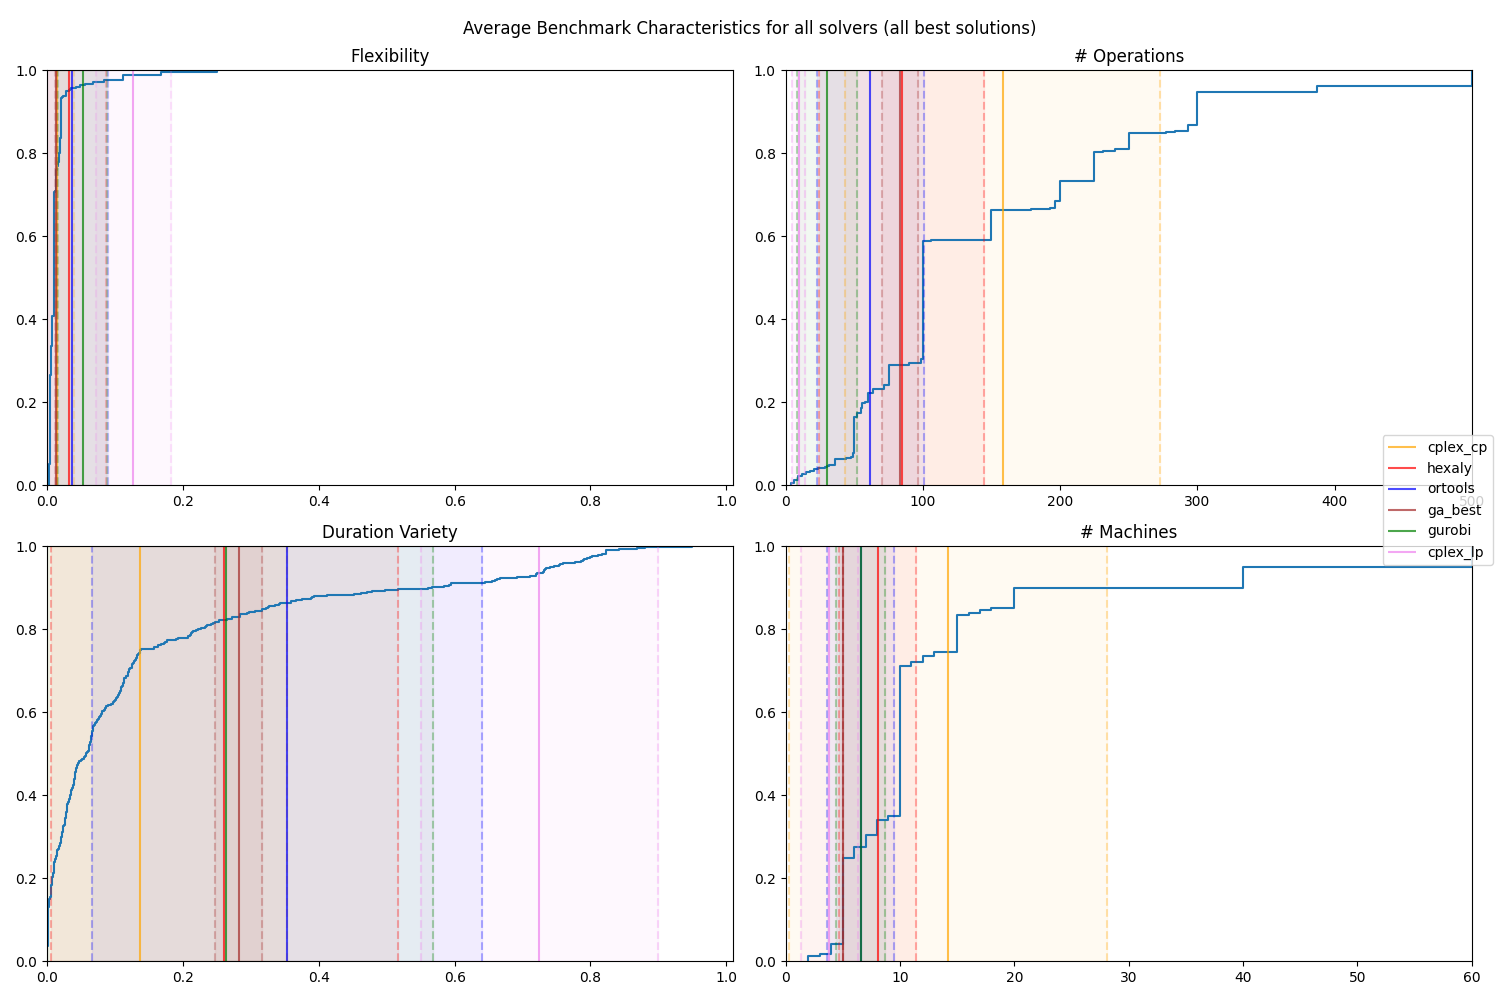

In [ ]:
fig = plt.figure(layout='tight', figsize=(15, 10))
solver_colors = {'ortools': 'blue', 'hexaly': 'red', 'cplex_cp': 'orange', 'ga_average': 'pink', 'ga_best': 'brown', 'gurobi': 'green', 'cplex_lp': 'violet'}
solver_labels = {'ortools': 'ORTOOLS', 'hexaly': 'HEXALY', 'cplex_cp': 'CPLEX-CP', 'ga_average': 'GA', 'ga_best': 'GA Average', 'gurobi': 'GUROBI', 'cplex_lp': 'CPLEX-LP'}
axs = fig.subplots(2, 2)
lines = []
labels = []
axs[0][0].ecdf(flexibility)
axs[0][0].set_title('Flexibility')
for solver in stats_data:
    lines.append(axs[0][0].vlines([stats_data[solver]['collected_best']['flexibility_mean']], 0.0, 1.0, label=solver_labels[solver], color=solver_colors[solver], alpha=0.7, linestyles='solid'))
    labels.append(solver)
    lb = stats_data[solver]['collected_best']['flexibility_mean']-stats_data[solver]['collected_best']['flexibility_stdv']
    ub = stats_data[solver]['collected_best']['flexibility_mean']+stats_data[solver]['collected_best']['flexibility_stdv']
    axs[0][0].vlines([lb], 0.0, 1.0, label=solver_labels[solver], color=solver_colors[solver], alpha=0.2, linestyles='dashed')
    axs[0][0].vlines([ub], 0.0, 1.0, label=solver_labels[solver], color=solver_colors[solver], alpha=0.2, linestyles='dashed')
    axs[0][0].axvspan(lb, ub, alpha=0.05, color=solver_colors[solver])
axs[1][0].ecdf(duration_variety)
axs[1][0].set_title('Duration Variety')
for solver in stats_data:
    axs[1][0].vlines([stats_data[solver]['collected_best']['duration_variety_mean']], 0.0, 1.0, label=solver_labels[solver], color=solver_colors[solver], alpha=0.7, linestyles='solid')
    lb = stats_data[solver]['collected_best']['duration_variety_mean']-stats_data[solver]['collected_best']['duration_variety_stdv']
    ub = stats_data[solver]['collected_best']['duration_variety_mean']+stats_data[solver]['collected_best']['duration_variety_stdv']
    axs[1][0].vlines([lb], 0.0, 1.0, label=solver_labels[solver], color=solver_colors[solver], alpha=0.3, linestyles='dashed')
    axs[1][0].vlines([ub], 0.0, 1.0, label=solver_labels[solver], color=solver_colors[solver], alpha=0.3, linestyles='dashed')
    axs[1][0].axvspan(lb, ub, alpha=0.05, color=solver_colors[solver])
axs[0][1].ecdf(n_operations)
axs[0][1].set_title('# Operations')
for solver in stats_data:
    axs[0][1].vlines([stats_data[solver]['collected_best']['operations_mean']], 0.0, 1.0, label=solver_labels[solver], color=solver_colors[solver], alpha=0.7, linestyles='solid')
    lb = stats_data[solver]['collected_best']['operations_mean']-stats_data[solver]['collected_best']['operations_stdv']
    ub = stats_data[solver]['collected_best']['operations_mean']+stats_data[solver]['collected_best']['operations_stdv']
    axs[0][1].vlines([lb], 0.0, 1.0, label=solver_labels[solver], color=solver_colors[solver], alpha=0.3, linestyles='dashed')
    axs[0][1].vlines([ub], 0.0, 1.0, label=solver_labels[solver], color=solver_colors[solver], alpha=0.3, linestyles='dashed')
    axs[0][1].axvspan(lb, ub, alpha=0.05, color=solver_colors[solver])
axs[1][1].ecdf(n_machines)
axs[1][1].set_title('# Machines')
for solver in stats_data:
    axs[1][1].vlines([stats_data[solver]['collected_best']['machines_mean']], 0.0, 1.0, label=solver_labels[solver], color=solver_colors[solver], alpha=0.7, linestyles='solid')
    lb = stats_data[solver]['collected_best']['machines_mean']-stats_data[solver]['collected_best']['machines_stdv']
    ub = stats_data[solver]['collected_best']['machines_mean']+stats_data[solver]['collected_best']['machines_stdv']
    axs[1][1].vlines([lb], 0.0, 1.0, label=solver_labels[solver], color=solver_colors[solver], alpha=0.3, linestyles='dashed')
    axs[1][1].vlines([ub], 0.0, 1.0, label=solver_labels[solver], color=solver_colors[solver], alpha=0.3, linestyles='dashed')
    axs[1][1].axvspan(lb, ub, alpha=0.05, color=solver_colors[solver])
axs[1][0].set_xlim(-0.001, 1.01)
axs[0][0].set_xlim(-0.001, 1.01)
axs[0][1].set_xlim(-0.001, 500.01)
axs[1][1].set_xlim(-0.001, 60.01)
fig.legend(loc='center right', handles=lines, labels=labels)
fig.suptitle('Average Benchmark Characteristics for all solvers (all best solutions)')

Text(0.5, 0.98, 'Average Benchmark Characteristics for all solvers (all best solutions)')

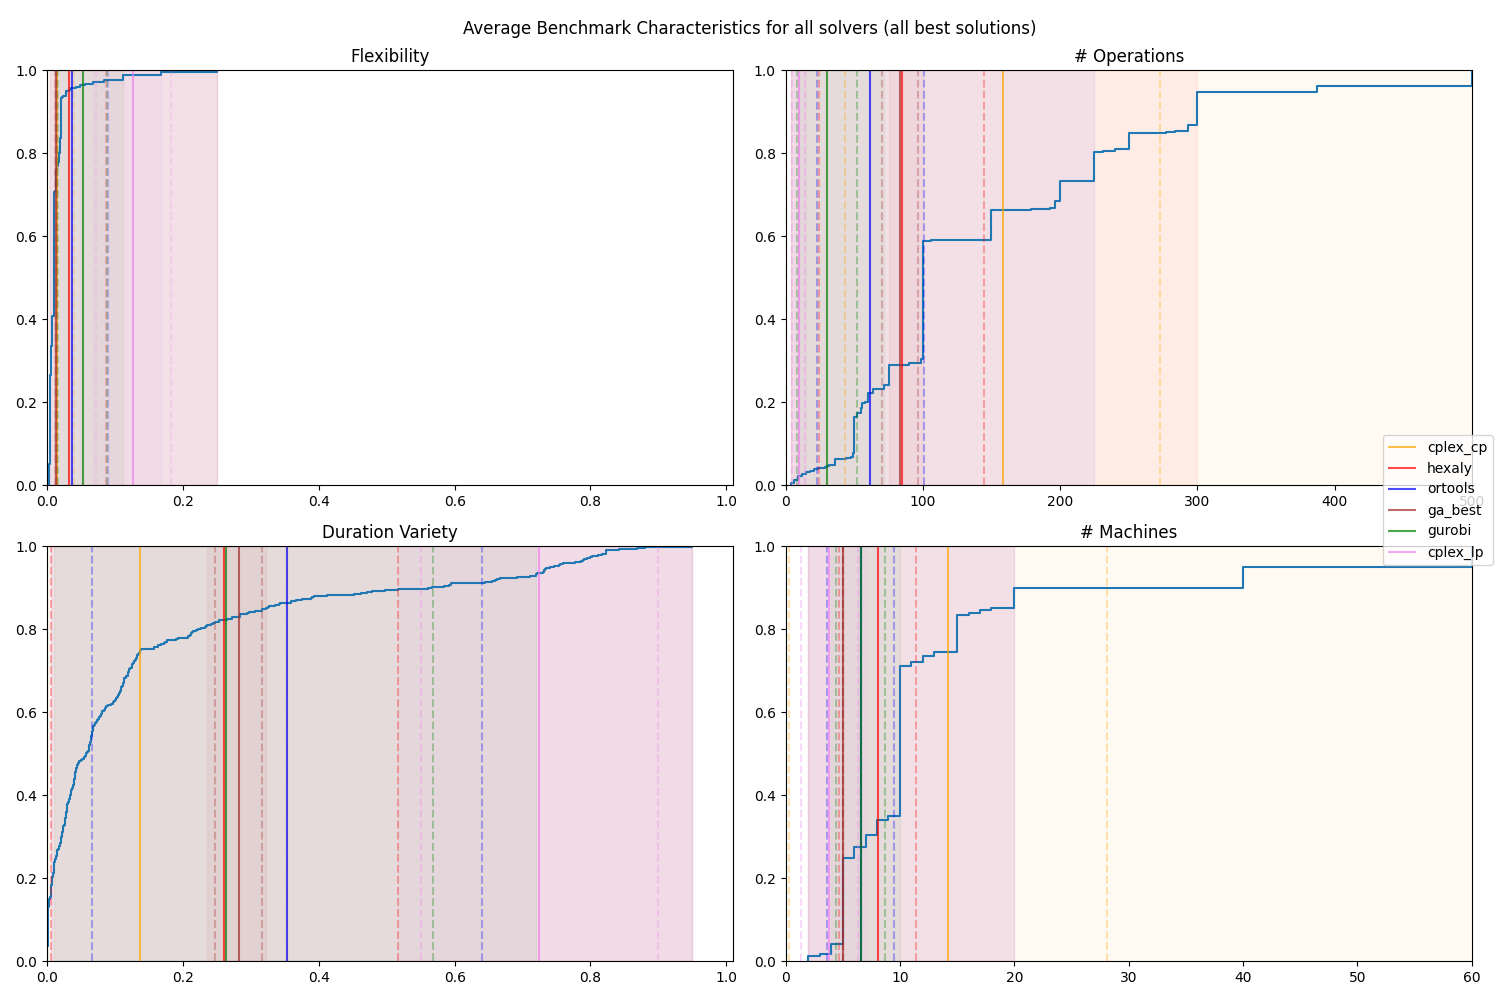

In [ ]:
fig = plt.figure(layout='tight', figsize=(15, 10))
solver_colors = {'ortools': 'blue', 'hexaly': 'red', 'cplex_cp': 'orange', 'ga_average': 'pink', 'ga_best': 'brown', 'gurobi': 'green', 'cplex_lp': 'violet'}
solver_labels = {'ortools': 'ORTOOLS', 'hexaly': 'HEXALY', 'cplex_cp': 'CPLEX-CP', 'ga_average': 'GA', 'ga_best': 'GA Average', 'gurobi': 'GUROBI', 'cplex_lp': 'CPLEX-LP'}
axs = fig.subplots(2, 2)
lines = []
labels = []
axs[0][0].ecdf(flexibility)
axs[0][0].set_title('Flexibility')
for solver in stats_data:
    lines.append(axs[0][0].vlines([stats_data[solver]['collected_best']['flexibility_mean']], 0.0, 1.0, label=solver_labels[solver], color=solver_colors[solver], alpha=0.7, linestyles='solid'))
    labels.append(solver)
    lb = stats_data[solver]['collected_best']['flexibility_mean']-stats_data[solver]['collected_best']['flexibility_stdv']
    ub = stats_data[solver]['collected_best']['flexibility_mean']+stats_data[solver]['collected_best']['flexibility_stdv']
    axs[0][0].vlines([lb], 0.0, 1.0, label=solver_labels[solver], color=solver_colors[solver], alpha=0.2, linestyles='dashed')
    axs[0][0].vlines([ub], 0.0, 1.0, label=solver_labels[solver], color=solver_colors[solver], alpha=0.2, linestyles='dashed')
    axs[0][0].axvspan(stats_data[solver]['collected_best']['flexibility_min'], stats_data[solver]['collected_best']['flexibility_max'], alpha=0.05, color=solver_colors[solver])
axs[1][0].ecdf(duration_variety)
axs[1][0].set_title('Duration Variety')
for solver in stats_data:
    axs[1][0].vlines([stats_data[solver]['collected_best']['duration_variety_mean']], 0.0, 1.0, label=solver_labels[solver], color=solver_colors[solver], alpha=0.7, linestyles='solid')
    lb = stats_data[solver]['collected_best']['duration_variety_mean']-stats_data[solver]['collected_best']['duration_variety_stdv']
    ub = stats_data[solver]['collected_best']['duration_variety_mean']+stats_data[solver]['collected_best']['duration_variety_stdv']
    axs[1][0].vlines([lb], 0.0, 1.0, label=solver_labels[solver], color=solver_colors[solver], alpha=0.3, linestyles='dashed')
    axs[1][0].vlines([ub], 0.0, 1.0, label=solver_labels[solver], color=solver_colors[solver], alpha=0.3, linestyles='dashed')
    axs[1][0].axvspan(stats_data[solver]['collected_best']['duration_variety_min'], stats_data[solver]['collected_best']['duration_variety_max'], alpha=0.05, color=solver_colors[solver])
axs[0][1].ecdf(n_operations)
axs[0][1].set_title('# Operations')
for solver in stats_data:
    axs[0][1].vlines([stats_data[solver]['collected_best']['operations_mean']], 0.0, 1.0, label=solver_labels[solver], color=solver_colors[solver], alpha=0.7, linestyles='solid')
    lb = stats_data[solver]['collected_best']['operations_mean']-stats_data[solver]['collected_best']['operations_stdv']
    ub = stats_data[solver]['collected_best']['operations_mean']+stats_data[solver]['collected_best']['operations_stdv']
    axs[0][1].vlines([lb], 0.0, 1.0, label=solver_labels[solver], color=solver_colors[solver], alpha=0.3, linestyles='dashed')
    axs[0][1].vlines([ub], 0.0, 1.0, label=solver_labels[solver], color=solver_colors[solver], alpha=0.3, linestyles='dashed')
    axs[0][1].axvspan(stats_data[solver]['collected_best']['operations_min'], stats_data[solver]['collected_best']['operations_max'], alpha=0.05, color=solver_colors[solver])
axs[1][1].ecdf(n_machines)
axs[1][1].set_title('# Machines')
for solver in stats_data:
    axs[1][1].vlines([stats_data[solver]['collected_best']['machines_mean']], 0.0, 1.0, label=solver_labels[solver], color=solver_colors[solver], alpha=0.7, linestyles='solid')
    lb = stats_data[solver]['collected_best']['machines_mean']-stats_data[solver]['collected_best']['machines_stdv']
    ub = stats_data[solver]['collected_best']['machines_mean']+stats_data[solver]['collected_best']['machines_stdv']
    axs[1][1].vlines([lb], 0.0, 1.0, label=solver_labels[solver], color=solver_colors[solver], alpha=0.3, linestyles='dashed')
    axs[1][1].vlines([ub], 0.0, 1.0, label=solver_labels[solver], color=solver_colors[solver], alpha=0.3, linestyles='dashed')
    axs[1][1].axvspan(stats_data[solver]['collected_best']['machines_min'], stats_data[solver]['collected_best']['machines_max'], alpha=0.05, color=solver_colors[solver])
axs[1][0].set_xlim(-0.001, 1.01)
axs[0][0].set_xlim(-0.001, 1.01)
axs[0][1].set_xlim(-0.001, 500.01)
axs[1][1].set_xlim(-0.001, 60.01)
fig.legend(loc='center right', handles=lines, labels=labels)
fig.suptitle('Average Benchmark Characteristics for all solvers (all best solutions)')

Text(0.5, 0.98, 'Average Benchmark Characteristics for all solvers (one best solutions)')

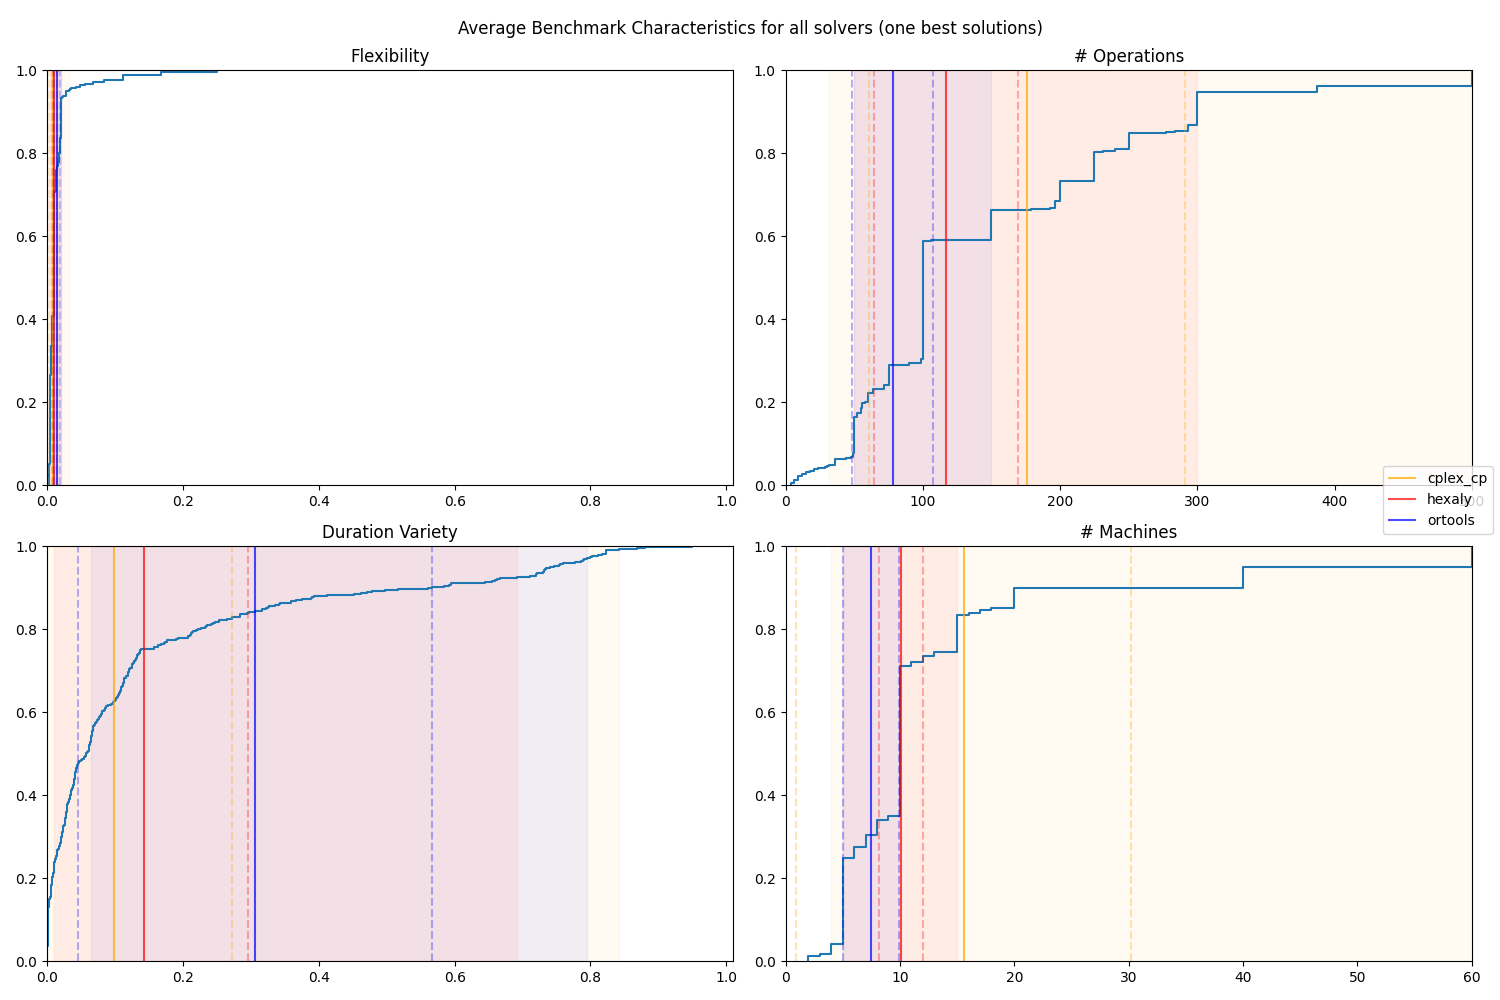

In [ ]:
fig = plt.figure(layout='tight', figsize=(15, 10))
solver_colors = {'ortools': 'blue', 'hexaly': 'red', 'cplex_cp': 'orange', 'ga_average': 'pink', 'ga_best': 'brown', 'gurobi': 'green', 'cplex_lp': 'violet'}
solver_labels = {'ortools': 'ORTOOLS', 'hexaly': 'HEXALY', 'cplex_cp': 'CPLEX-CP', 'ga_average': 'GA', 'ga_best': 'GA Average', 'gurobi': 'GUROBI', 'cplex_lp': 'CPLEX-LP'}
axs = fig.subplots(2, 2)
lines = []
labels = []
axs[0][0].ecdf(flexibility)
axs[0][0].set_title('Flexibility')
for solver in stats_data:
    if 'one_best' in stats_data[solver]:
        lines.append(axs[0][0].vlines([stats_data[solver]['one_best']['flexibility_mean']], 0.0, 1.0, label=solver_labels[solver], color=solver_colors[solver], alpha=0.7, linestyles='solid'))
        labels.append(solver)
        lb = stats_data[solver]['one_best']['flexibility_mean']-stats_data[solver]['one_best']['flexibility_stdv']
        ub = stats_data[solver]['one_best']['flexibility_mean']+stats_data[solver]['one_best']['flexibility_stdv']
        axs[0][0].vlines([lb], 0.0, 1.0, label=solver_labels[solver], color=solver_colors[solver], alpha=0.2, linestyles='dashed')
        axs[0][0].vlines([ub], 0.0, 1.0, label=solver_labels[solver], color=solver_colors[solver], alpha=0.2, linestyles='dashed')
        axs[0][0].axvspan(stats_data[solver]['one_best']['flexibility_min'], stats_data[solver]['one_best']['flexibility_max'], alpha=0.05, color=solver_colors[solver])
axs[1][0].ecdf(duration_variety)
axs[1][0].set_title('Duration Variety')
for solver in stats_data:
    if 'one_best' in stats_data[solver]:
        axs[1][0].vlines([stats_data[solver]['one_best']['duration_variety_mean']], 0.0, 1.0, label=solver_labels[solver], color=solver_colors[solver], alpha=0.7, linestyles='solid')
        lb = stats_data[solver]['one_best']['duration_variety_mean']-stats_data[solver]['one_best']['duration_variety_stdv']
        ub = stats_data[solver]['one_best']['duration_variety_mean']+stats_data[solver]['one_best']['duration_variety_stdv']
        axs[1][0].vlines([lb], 0.0, 1.0, label=solver_labels[solver], color=solver_colors[solver], alpha=0.3, linestyles='dashed')
        axs[1][0].vlines([ub], 0.0, 1.0, label=solver_labels[solver], color=solver_colors[solver], alpha=0.3, linestyles='dashed')
        axs[1][0].axvspan(stats_data[solver]['one_best']['duration_variety_min'], stats_data[solver]['one_best']['duration_variety_max'], alpha=0.05, color=solver_colors[solver])
axs[0][1].ecdf(n_operations)
axs[0][1].set_title('# Operations')
for solver in stats_data:
    if 'one_best' in stats_data[solver]:
        axs[0][1].vlines([stats_data[solver]['one_best']['operations_mean']], 0.0, 1.0, label=solver_labels[solver], color=solver_colors[solver], alpha=0.7, linestyles='solid')
        lb = stats_data[solver]['one_best']['operations_mean']-stats_data[solver]['one_best']['operations_stdv']
        ub = stats_data[solver]['one_best']['operations_mean']+stats_data[solver]['one_best']['operations_stdv']
        axs[0][1].vlines([lb], 0.0, 1.0, label=solver_labels[solver], color=solver_colors[solver], alpha=0.3, linestyles='dashed')
        axs[0][1].vlines([ub], 0.0, 1.0, label=solver_labels[solver], color=solver_colors[solver], alpha=0.3, linestyles='dashed')
        axs[0][1].axvspan(stats_data[solver]['one_best']['operations_min'], stats_data[solver]['one_best']['operations_max'], alpha=0.05, color=solver_colors[solver])
axs[1][1].ecdf(n_machines)
axs[1][1].set_title('# Machines')
for solver in stats_data:
    if 'one_best' in stats_data[solver]:
        axs[1][1].vlines([stats_data[solver]['one_best']['machines_mean']], 0.0, 1.0, label=solver_labels[solver], color=solver_colors[solver], alpha=0.7, linestyles='solid')
        lb = stats_data[solver]['one_best']['machines_mean']-stats_data[solver]['one_best']['machines_stdv']
        ub = stats_data[solver]['one_best']['machines_mean']+stats_data[solver]['one_best']['machines_stdv']
        axs[1][1].vlines([lb], 0.0, 1.0, label=solver_labels[solver], color=solver_colors[solver], alpha=0.3, linestyles='dashed')
        axs[1][1].vlines([ub], 0.0, 1.0, label=solver_labels[solver], color=solver_colors[solver], alpha=0.3, linestyles='dashed')
        axs[1][1].axvspan(stats_data[solver]['one_best']['machines_min'], stats_data[solver]['one_best']['machines_max'], alpha=0.05, color=solver_colors[solver])
axs[1][0].set_xlim(-0.001, 1.01)
axs[0][0].set_xlim(-0.001, 1.01)
axs[0][1].set_xlim(-0.001, 500.01)
axs[1][1].set_xlim(-0.001, 60.01)
fig.legend(loc='center right', handles=lines, labels=labels)
fig.suptitle('Average Benchmark Characteristics for all solvers (one best solutions)')

In [ ]:
best_solvers

{'BehnkeGeiger_10': ['cplex_cp'],
 'BehnkeGeiger_11': ['cplex_cp'],
 'BehnkeGeiger_12': ['cplex_cp'],
 'BehnkeGeiger_13': ['cplex_cp'],
 'BehnkeGeiger_14': ['cplex_cp'],
 'BehnkeGeiger_15': ['cplex_cp'],
 'BehnkeGeiger_16': ['cplex_cp'],
 'BehnkeGeiger_17': ['cplex_cp'],
 'BehnkeGeiger_18': ['cplex_cp'],
 'BehnkeGeiger_19': ['cplex_cp'],
 'BehnkeGeiger_1': ['cplex_cp', 'ortools'],
 'BehnkeGeiger_20': ['cplex_cp'],
 'BehnkeGeiger_21': ['cplex_cp'],
 'BehnkeGeiger_22': ['cplex_cp'],
 'BehnkeGeiger_23': ['cplex_cp'],
 'BehnkeGeiger_24': ['cplex_cp'],
 'BehnkeGeiger_25': ['cplex_cp'],
 'BehnkeGeiger_26': ['cplex_cp'],
 'BehnkeGeiger_27': ['cplex_cp'],
 'BehnkeGeiger_28': ['cplex_cp'],
 'BehnkeGeiger_29': ['cplex_cp'],
 'BehnkeGeiger_2': ['cplex_cp'],
 'BehnkeGeiger_30': ['cplex_cp'],
 'BehnkeGeiger_31': ['cplex_cp'],
 'BehnkeGeiger_32': ['cplex_cp'],
 'BehnkeGeiger_33': ['cplex_cp'],
 'BehnkeGeiger_34': ['cplex_cp'],
 'BehnkeGeiger_35': ['cplex_cp'],
 'BehnkeGeiger_36': ['cplex_cp'],
 'Beh

C:\Users\huda\AppData\Local\Temp\ipykernel_20904\2572860692.py:23: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  fig.legend(loc='center right', handles=lines, labels=labels)


Text(0.5, 0.98, 'Average Benchmark Characteristics for all solvers (one best solutions)')

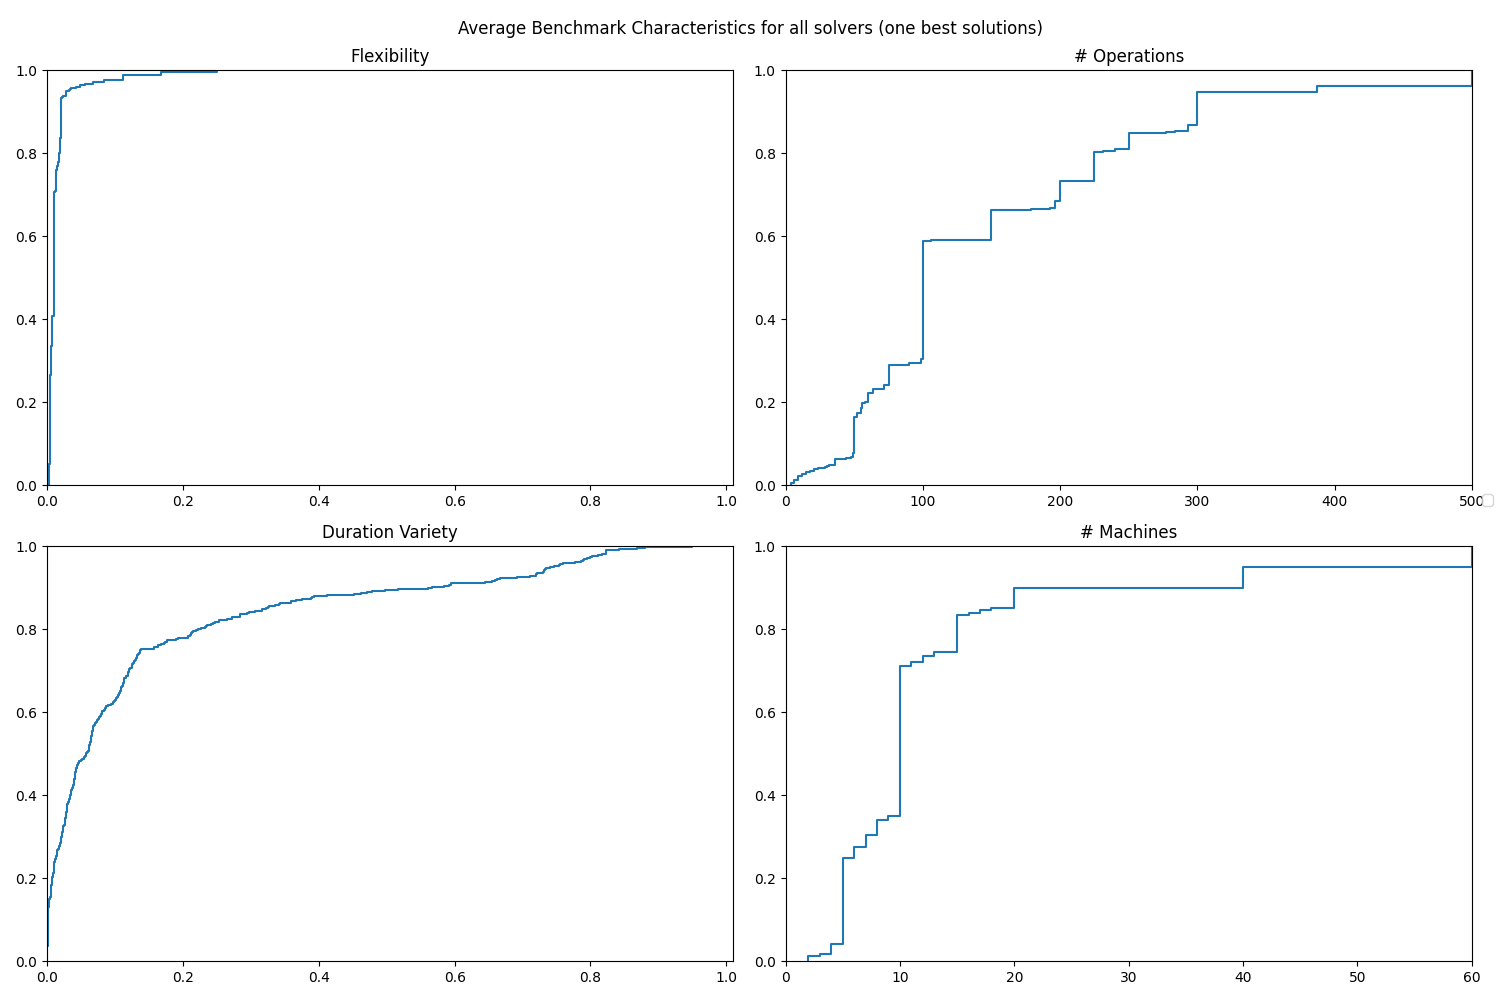

In [ ]:
fig = plt.figure(layout='tight', figsize=(15, 10))
solver_colors = {'ortools': 'blue', 'hexaly': 'red', 'cplex_cp': 'orange', 'ga_average': 'pink', 'ga_best': 'brown', 'gurobi': 'green', 'cplex_lp': 'violet'}
solver_labels = {'ortools': 'ORTOOLS', 'hexaly': 'HEXALY', 'cplex_cp': 'CPLEX-CP', 'ga_average': 'GA', 'ga_best': 'GA Average', 'gurobi': 'GUROBI', 'cplex_lp': 'CPLEX-LP'}
axs = fig.subplots(2, 2)
lines = []
labels = []
axs[0][0].ecdf(flexibility)
axs[0][0].set_title('Flexibility')

axs[1][0].ecdf(duration_variety)
axs[1][0].set_title('Duration Variety')

axs[0][1].ecdf(n_operations)
axs[0][1].set_title('# Operations')

axs[1][1].ecdf(n_machines)
axs[1][1].set_title('# Machines')

axs[1][0].set_xlim(-0.001, 1.01)
axs[0][0].set_xlim(-0.001, 1.01)
axs[0][1].set_xlim(-0.001, 500.01)
axs[1][1].set_xlim(-0.001, 60.01)
fig.legend(loc='center right', handles=lines, labels=labels)
fig.suptitle('Average Benchmark Characteristics for all solvers (one best solutions)')

In [ ]:
def get_stats(data):
    result = dict()
    result['count'] = len(data)

    result['operations_mean'] = statistics.mean([instance['n_operations'] for instance in data])
    result['operations_max'] = max([instance['n_operations'] for instance in data])
    result['operations_min'] = min([instance['n_operations'] for instance in data])
    result['operations_stdv'] = statistics.stdev([instance['n_operations'] for instance in data])
    result['flexibility_mean'] = statistics.mean([instance['flexibility'] for instance in data])
    result['flexibility_max'] = max([instance['flexibility'] for instance in data])
    result['flexibility_min'] = min([instance['flexibility'] for instance in data])
    result['flexibility_stdv'] = statistics.stdev([instance['flexibility'] for instance in data])
    result['duration_variety_mean'] = statistics.mean([instance['duration_variety'] for instance in data])
    result['duration_variety_max'] = max([instance['duration_variety'] for instance in data])
    result['duration_variety_min'] = min([instance['duration_variety'] for instance in data])
    result['duration_variety_stdv'] = statistics.stdev([instance['duration_variety'] for instance in data])
    result['machines_mean'] = statistics.mean([instance['n_machines'] for instance in data])
    result['machines_max'] = max([instance['n_machines'] for instance in data])
    result['machines_min'] = min([instance['n_machines'] for instance in data])
    result['machines_stdv'] = statistics.stdev([instance['n_machines'] for instance in data])
    return result

collected_data = {'one_best': [], 'some_best': [], 'all': [], 'none': []} # none doesn't exist
for instance in best_solvers:
    n_solvers = len(best_solvers[instance])
    if 'ga_average' in best_solvers[instance]:
        n_solvers -= 1
    all_solved = n_solvers == len(solvers)
    if len(best_solvers[instance]) == 1:
        collected_data['one_best'].append(benchmark_data[instance])
    elif all_solved:
        collected_data['all'].append(benchmark_data[instance])
    else:
        collected_data['some_best'].append(benchmark_data[instance])

one_best_data = get_stats(collected_data['one_best'])
some_best_data = get_stats(collected_data['some_best'])
all_best_data = get_stats(collected_data['all'])

StatisticsError: mean requires at least one data point

In [ ]:
some_best_data

In [ ]:
fig = plt.figure(layout='tight', figsize=(15, 10))
solver_colors = {'ortools': 'blue', 'hexaly': 'red', 'cplex_cp': 'orange', 'ga_average': 'pink', 'ga_best': 'brown', 'gurobi': 'green', 'cplex_lp': 'violet'}
solver_labels = {'ortools': 'ORTOOLS', 'hexaly': 'HEXALY', 'cplex_cp': 'CPLEX-CP', 'ga_average': 'GA', 'ga_best': 'GA Average', 'gurobi': 'GUROBI', 'cplex_lp': 'CPLEX-LP'}
axs = fig.subplots(2, 2)
lines = []
labels = ['One Best', 'Multiple Best', 'All Best']
axs[0][0].ecdf(flexibility)
axs[0][0].set_title('Flexibility')

lines.append(axs[0][0].vlines([one_best_data['flexibility_mean']], 0.0, 1.0, alpha=0.5, linestyles='solid', color='red'))
#axs[0][0].vlines([one_best_data['flexibility_stdv']], 0.0, 1.0, alpha=0.5, linestyles='dashed', color='red')
lines.append(axs[0][0].vlines([some_best_data['flexibility_mean']], 0.0, 1.0, alpha=0.5, linestyles='solid', color='orange'))
#axs[0][0].vlines([some_best_data['flexibility_stdv']], 0.0, 1.0, alpha=0.5, linestyles='dashed', color='orange')
lines.append(axs[0][0].vlines([all_best_data['flexibility_mean']], 0.0, 1.0, alpha=0.5, linestyles='solid', color='green'))
#axs[0][0].vlines([all_best_data['flexibility_stdv']], 0.0, 1.0, alpha=0.5, linestyles='dashed', color='green')

axs[1][0].ecdf(duration_variety)
axs[1][0].set_title('Duration Variety')

axs[1][0].vlines([one_best_data['duration_variety_mean']], 0.0, 1.0, alpha=0.5, linestyles='solid', color='red')
#axs[1][0].vlines([one_best_data['duration_variety_stdv']], 0.0, 1.0, alpha=0.5, linestyles='dashed', color='red')
axs[1][0].vlines([some_best_data['duration_variety_mean']], 0.0, 1.0, alpha=0.5, linestyles='solid', color='orange')
#axs[1][0].vlines([some_best_data['duration_variety_stdv']], 0.0, 1.0, alpha=0.5, linestyles='dashed', color='orange')
axs[1][0].vlines([all_best_data['duration_variety_mean']], 0.0, 1.0, alpha=0.5, linestyles='solid', color='green')
#axs[1][0].vlines([all_best_data['duration_variety_stdv']], 0.0, 1.0, alpha=0.5, linestyles='dashed', color='green')


axs[0][1].ecdf(n_operations)
axs[0][1].set_title('# Operations')

axs[0][1].vlines([one_best_data['operations_mean']], 0.0, 1.0, alpha=0.5, linestyles='solid', color='red')
#axs[0][1].vlines([one_best_data['operations_stdv']], 0.0, 1.0, alpha=0.5, linestyles='dashed', color='red')
axs[0][1].vlines([some_best_data['operations_mean']], 0.0, 1.0, alpha=0.5, linestyles='solid', color='orange')
#axs[0][1].vlines([some_best_data['operations_stdv']], 0.0, 1.0, alpha=0.5, linestyles='dashed', color='orange')
axs[0][1].vlines([all_best_data['operations_mean']], 0.0, 1.0, alpha=0.5, linestyles='solid', color='green')
#axs[0][1].vlines([all_best_data['operations_stdv']], 0.0, 1.0, alpha=0.5, linestyles='dashed', color='green')

axs[1][1].ecdf(n_machines)
axs[1][1].set_title('# Machines')

axs[1][1].vlines([one_best_data['machines_mean']], 0.0, 1.0, alpha=0.5, linestyles='solid', color='red')
#axs[1][1].vlines([one_best_data['machines_stdv']], 0.0, 1.0, alpha=0.5, linestyles='dashed', color='red')
axs[1][1].vlines([some_best_data['machines_mean']], 0.0, 1.0, alpha=0.5, linestyles='solid', color='orange')
#axs[1][1].vlines([some_best_data['machines_stdv']], 0.0, 1.0, alpha=0.5, linestyles='dashed', color='orange')
axs[1][1].vlines([all_best_data['machines_mean']], 0.0, 1.0, alpha=0.5, linestyles='solid', color='green')
#axs[1][1].vlines([all_best_data['machines_stdv']], 0.0, 1.0, alpha=0.5, linestyles='dashed', color='green')

axs[1][0].set_xlim(-0.001, 1.01)
axs[0][0].set_xlim(-0.001, 1.01)
axs[0][1].set_xlim(-0.001, 500.01)
axs[1][1].set_xlim(-0.001, 60.01)
fig.legend(loc='center right', handles=lines, labels=labels)
fig.suptitle('Average Benchmark Characteristics for solved benchmarks')

In [ ]:
fig = plt.figure(layout='tight', figsize=(15, 10))
solver_colors = {'ortools': 'blue', 'hexaly': 'red', 'cplex_cp': 'orange', 'ga_average': 'pink', 'ga_best': 'brown', 'gurobi': 'green', 'cplex_lp': 'violet'}
solver_labels = {'ortools': 'ORTOOLS', 'hexaly': 'HEXALY', 'cplex_cp': 'CPLEX-CP', 'ga_average': 'GA', 'ga_best': 'GA Average', 'gurobi': 'GUROBI', 'cplex_lp': 'CPLEX-LP'}
axs = fig.subplots(2, 2)
lines = []
labels = ['One Best', 'Multiple Best', 'All Best']
axs[0][0].ecdf(flexibility)
axs[0][0].set_title('Flexibility')

lines.append(axs[0][0].vlines([one_best_data['flexibility_mean']], 0.0, 1.0, alpha=0.5, linestyles='solid', color='red'))
lines.append(axs[0][0].vlines([some_best_data['flexibility_mean']], 0.0, 1.0, alpha=0.5, linestyles='solid', color='orange'))
lines.append(axs[0][0].vlines([all_best_data['flexibility_mean']], 0.0, 1.0, alpha=0.5, linestyles='solid', color='green'))

for solver in stats_data:
    lines.append(axs[0][0].vlines([stats_data[solver]['collected_best']['flexibility_mean']], 0.0, 1.0, label=solver_labels[solver], color=solver_colors[solver], alpha=0.5, linestyles='dashed'))
    labels.append(solver)
    
axs[1][0].ecdf(duration_variety)
axs[1][0].set_title('Duration Variety')

axs[1][0].vlines([one_best_data['duration_variety_mean']], 0.0, 1.0, alpha=0.5, linestyles='solid', color='red')
axs[1][0].vlines([some_best_data['duration_variety_mean']], 0.0, 1.0, alpha=0.5, linestyles='solid', color='orange')
axs[1][0].vlines([all_best_data['duration_variety_mean']], 0.0, 1.0, alpha=0.5, linestyles='solid', color='green')

for solver in stats_data:
    axs[1][0].vlines([stats_data[solver]['collected_best']['duration_variety_mean']], 0.0, 1.0, label=solver_labels[solver], color=solver_colors[solver], alpha=0.5, linestyles='dashed')

axs[0][1].ecdf(n_operations)
axs[0][1].set_title('# Operations')

axs[0][1].vlines([one_best_data['operations_mean']], 0.0, 1.0, alpha=0.5, linestyles='solid', color='red')
axs[0][1].vlines([some_best_data['operations_mean']], 0.0, 1.0, alpha=0.5, linestyles='solid', color='orange')
axs[0][1].vlines([all_best_data['operations_mean']], 0.0, 1.0, alpha=0.5, linestyles='solid', color='green')

for solver in stats_data:
    axs[0][1].vlines([stats_data[solver]['collected_best']['operations_mean']], 0.0, 1.0, label=solver_labels[solver], color=solver_colors[solver], alpha=0.5, linestyles='dashed')

axs[1][1].ecdf(n_machines)
axs[1][1].set_title('# Machines')

axs[1][1].vlines([one_best_data['machines_mean']], 0.0, 1.0, alpha=0.5, linestyles='solid', color='red')
axs[1][1].vlines([some_best_data['machines_mean']], 0.0, 1.0, alpha=0.5, linestyles='solid', color='orange')
axs[1][1].vlines([all_best_data['machines_mean']], 0.0, 1.0, alpha=0.5, linestyles='solid', color='green')

for solver in stats_data:
    axs[1][1].vlines([stats_data[solver]['collected_best']['machines_mean']], 0.0, 1.0, label=solver_labels[solver], color=solver_colors[solver], alpha=0.5, linestyles='dashed')

axs[1][0].set_xlim(-0.001, 1.01)
axs[0][0].set_xlim(-0.001, 1.01)
axs[0][1].set_xlim(-0.001, 500.01)
axs[1][1].set_xlim(-0.001, 60.01)
fig.legend(loc='center right', handles=lines, labels=labels)
fig.suptitle('Average Benchmark Characteristics for solved benchmarks')

In [ ]:
for instance in best_solvers:
    if len(best_solvers[instance]) == 1 and 'ga' in best_solvers[instance]:
        print(instance)
    elif len(best_solvers[instance]) == 2 and 'ga_best' in best_solvers[instance] and 'ga_average' in best_solvers[instance]:
        print(instance)

In [ ]:
def get_stats(data):
    result = dict()
    result['count'] = len(data)

    result['operations_mean'] = statistics.mean([instance['n_operations'] for instance in data])
    result['operations_max'] = max([instance['n_operations'] for instance in data])
    result['operations_min'] = min([instance['n_operations'] for instance in data])
    result['operations_stdv'] = statistics.stdev([instance['n_operations'] for instance in data])
    result['flexibility_mean'] = statistics.mean([instance['flexibility'] for instance in data])
    result['flexibility_max'] = max([instance['flexibility'] for instance in data])
    result['flexibility_min'] = min([instance['flexibility'] for instance in data])
    result['flexibility_stdv'] = statistics.stdev([instance['flexibility'] for instance in data])
    result['duration_variety_mean'] = statistics.mean([instance['duration_variety'] for instance in data])
    result['duration_variety_max'] = max([instance['duration_variety'] for instance in data])
    result['duration_variety_min'] = min([instance['duration_variety'] for instance in data])
    result['duration_variety_stdv'] = statistics.stdev([instance['duration_variety'] for instance in data])
    result['machines_mean'] = statistics.mean([instance['n_machines'] for instance in data])
    result['machines_max'] = max([instance['n_machines'] for instance in data])
    result['machines_min'] = min([instance['n_machines'] for instance in data])
    result['machines_stdv'] = statistics.stdev([instance['n_machines'] for instance in data])
    return result
instances = []
for instance in best_solvers:
    if len(best_solvers[instance]) == 1 and 'ga' in best_solvers[instance]:
        instances.append(benchmark_data[instance])
stats = get_stats(instances)
for stat in stats:
    print(f'{stat}: {stats[stat]}')


In [ ]:
def get_stats(data):
    result = dict()
    result['count'] = len(data)

    result['operations_mean'] = statistics.mean([instance['n_operations'] for instance in data])
    result['operations_max'] = max([instance['n_operations'] for instance in data])
    result['operations_min'] = min([instance['n_operations'] for instance in data])
    result['operations_stdv'] = statistics.stdev([instance['n_operations'] for instance in data])
    result['flexibility_mean'] = statistics.mean([instance['flexibility'] for instance in data])
    result['flexibility_max'] = max([instance['flexibility'] for instance in data])
    result['flexibility_min'] = min([instance['flexibility'] for instance in data])
    result['flexibility_stdv'] = statistics.stdev([instance['flexibility'] for instance in data])
    result['duration_variety_mean'] = statistics.mean([instance['duration_variety'] for instance in data])
    result['duration_variety_max'] = max([instance['duration_variety'] for instance in data])
    result['duration_variety_min'] = min([instance['duration_variety'] for instance in data])
    result['duration_variety_stdv'] = statistics.stdev([instance['duration_variety'] for instance in data])
    result['machines_mean'] = statistics.mean([instance['n_machines'] for instance in data])
    result['machines_max'] = max([instance['n_machines'] for instance in data])
    result['machines_min'] = min([instance['n_machines'] for instance in data])
    result['machines_stdv'] = statistics.stdev([instance['n_machines'] for instance in data])
    return result
instances = []
for instance in best_solvers:
    if 'ga' in best_solvers[instance]:
        instances.append(benchmark_data[instance])
stats = get_stats(instances)
for stat in stats:
    print(f'{stat}: {stats[stat]}')


In [ ]:
def get_stats(data):
    result = dict()
    result['count'] = len(data)

    result['operations_mean'] = statistics.mean([instance['n_operations'] for instance in data])
    #result['operations_max'] = max([instance['n_operations'] for instance in data])
    #result['operations_min'] = min([instance['n_operations'] for instance in data])
    result['operations_stdv'] = statistics.stdev([instance['n_operations'] for instance in data])
    result['flexibility_mean'] = statistics.mean([instance['flexibility'] for instance in data])
    #result['flexibility_max'] = max([instance['flexibility'] for instance in data])
    #result['flexibility_min'] = min([instance['flexibility'] for instance in data])
    result['flexibility_stdv'] = statistics.stdev([instance['flexibility'] for instance in data])
    result['duration_variety_mean'] = statistics.mean([instance['duration_variety'] for instance in data])
    #result['duration_variety_max'] = max([instance['duration_variety'] for instance in data])
    #result['duration_variety_min'] = min([instance['duration_variety'] for instance in data])
    result['duration_variety_stdv'] = statistics.stdev([instance['duration_variety'] for instance in data])
    result['machines_mean'] = statistics.mean([instance['n_machines'] for instance in data])
    #result['machines_max'] = max([instance['n_machines'] for instance in data])
    #result['machines_min'] = min([instance['n_machines'] for instance in data])
    result['machines_stdv'] = statistics.stdev([instance['n_machines'] for instance in data])
    return result

In [ ]:
solvers[1] = 'ga'

In [ ]:
solvers

In [ ]:
def to_table_rows(data, key):
    table = ''
    
    row = []
    if key == "one":
        name = 'Single Best'
    elif key == "some":
        name = 'Shared Best'
    elif key == "optimal":
        name = 'Known Optimum'
    else:
        name = "Combined"
    row.append(key)
    row.append('{:.0f}'.format(data['count']))
    row.append('{:.4f}'.format(data['machines_mean']))
    row.append('{:.4f}'.format(data['machines_stdv']))
    row.append('{:.4f}'.format(data['operations_mean']))
    row.append('{:.4f}'.format(data['operations_stdv']))
    row.append('{:.4f}'.format(data['flexibility_mean']))
    row.append('{:.4f}'.format(data['flexibility_stdv']))
    row.append('{:.4f}'.format(data['duration_variety_mean']))
    row.append('{:.6f}'.format(data['duration_variety_stdv']))
    table += ' & '.join(row)[:-1] + '\\'
    return table[:-1]

In [ ]:
for solver in solvers:
    instances = []
    for instance in best_solvers:
        if len(best_solvers[instance]) == 1 and solver in best_solvers[instance]:
            instances.append(benchmark_data[instance])
    if len(instances) > 0:
        stats = get_stats(instances)
    else:
        stats = None

    print(f'{solver}:\n {to_table_rows(stats, "Single Best") if stats else "No data"}')

In [ ]:
for solver in solvers:
    instances = []
    for instance in best_solvers:
        if len(best_solvers[instance]) > 1 and solver in best_solvers[instance]:
            instances.append(benchmark_data[instance])
    if len(instances) > 0:
        stats = get_stats(instances)
    else:
        stats = 'No data'
    print(f'{solver}:\n{to_table_rows(stats, "Shared Best")}')

In [ ]:
for solver in solvers:
    instances = []
    for instance in best_solvers:
        if solver in best_solvers[instance]:
            instances.append(benchmark_data[instance])
    if len(instances) > 0:
        stats = get_stats(instances)
    else:
        stats = 'No data'
    print(f'{solver}:\n{to_table_rows(stats, "Combined")}')

In [ ]:
for solver in solvers:
    instances = []
    if solver == 'ga':
        solver = 'ga_best'
    for instance in optimal_solvers:
        if solver in optimal_solvers[instance]:
            instances.append(benchmark_data[instance])
    if len(instances) > 0:
        stats = get_stats(instances)
    else:
        stats = None
    print(f'{solver}:\n{to_table_rows(stats, "Known Optimum") if stats else "No data"}')

In [ ]:
optimal_benchmarks = []
for benchmark in optimal_solvers:
    if len(optimal_solvers[benchmark]) > 0:
        optimal_benchmarks.append(benchmark)

In [ ]:
print(optimal_benchmarks)

In [ ]:
print(one_best_data)

In [ ]:
optimal_benchmarks = []
for benchmark in optimal_solvers:
    if len(optimal_solvers[benchmark]) > 0:
        if 'ga_best' in optimal_solvers[benchmark]:
            optimal_benchmarks.append(benchmark)


In [ ]:
optimal_benchmarks

In [ ]:
dv = [benchmark_data[benchmark]['duration_variety'] for benchmark in benchmark_data]
print(max(dv))
print(min(dv))
print(statistics.mean(dv))
print(list(benchmark_data.keys())[dv.index(min(dv))])

In [ ]:
benchmark_data['Behnke58']

In [ ]:
best_solvers

In [ ]:
x1 = []
x2 = []
x3 = []
x4 = []
labels = []
y = []
for benchmark in benchmark_data:
    
    average_unique = len(benchmark_data[benchmark]['additional_metrics']['d_unique']) / benchmark_data[benchmark]['n_operations']
    unique_portion = len(benchmark_data[benchmark]['additional_metrics']['d_unique']) / len(benchmark_data[benchmark]['additional_metrics']['d_distinct'])
    shared_portion = len(benchmark_data[benchmark]['additional_metrics']['d_shared']) / len(benchmark_data[benchmark]['additional_metrics']['d_distinct'])
    x1.append(average_unique)
    x2.append(unique_portion)
    x3.append(shared_portion)
    x4.append(benchmark_data[benchmark]['duration_variety'])
    y.append(len(best_solvers[benchmark]))


In [ ]:
sx1y = sorted(zip(x1, y))
x1s = [x for x, _ in sx1y]
y1s = [y for _, y in sx1y]
sx2y = sorted(zip(x2, y))
x2s = [x for x, _ in sx2y]
y2s = [y for _, y in sx2y]
sx3y = sorted(zip(x3, y))
x3s = [x for x, _ in sx3y]
y3s = [y for _, y in sx3y]
sx4y = sorted(zip(x4, y))
x4s = [x for x, _ in sx4y]
y4s = [y for _, y in sx4y]

In [ ]:
fig = plt.figure(layout='tight', figsize=(15, 10))

axs = fig.subplots(2, 2)

axs[0][0].step(x1s, y1s)
axs[0][1].step(x2s, y2s)
axs[1][0].step(x3s, y3s)
axs[1][1].step(x4s, y4s)
plt.show()

In [ ]:
fig = plt.figure(layout='tight', figsize=(15, 10))

axs = fig.subplots(2, 2)

axs[0][0].bar(x1, y, edgecolor='black', color='none', width=0.1)
axs[0][1].bar(x2, y, edgecolor='black', color='none', width=0.1)
axs[1][0].bar(x3, y, edgecolor='black', color='none', width=0.1)
axs[1][1].bar(x4, y, edgecolor='black', color='none', width=0.1)
plt.show()

In [ ]:
solvers

In [ ]:
x1 = []
x2 = []
x3 = []
x4 = []
labels = []
y = []
plot_data = dict()
for solver in solvers:
    plot_data[solver] = {'x1': [], 'x2': [], 'x3': [], 'x4': [], 'y1': [], 'y2': [], 'y3': [], 'y4': []}
plot_data['multiple'] = {'x1': [], 'x2': [], 'x3': [], 'x4': [], 'y1': [], 'y2': [], 'y3': [], 'y4': []}
plot_data['ga+'] = {'x1': [], 'x2': [], 'x3': [], 'x4': [], 'y1': [], 'y2': [], 'y3': [], 'y4': []}
for benchmark in benchmark_data:
    
    average_unique = len(benchmark_data[benchmark]['additional_metrics']['d_unique']) / benchmark_data[benchmark]['n_operations']
    unique_portion = len(benchmark_data[benchmark]['additional_metrics']['d_unique']) / len(benchmark_data[benchmark]['additional_metrics']['d_distinct'])
    shared_portion = len(benchmark_data[benchmark]['additional_metrics']['d_shared']) / len(benchmark_data[benchmark]['additional_metrics']['d_distinct'])
    #x1.append(average_unique)
    #x2.append(unique_portion)
    #x3.append(shared_portion)
    #x4.append(benchmark_data[benchmark]['duration_variety'])
    #y.append(benchmark_data[benchmark]['n_operations'])
    key = 'multiple'
    if len(best_solvers[benchmark]) == 1:
        key = best_solvers[benchmark][0]
    elif 'ga' in best_solvers[benchmark]:
        key = 'ga+'
    plot_data[key]['x1'].append(average_unique)
    plot_data[key]['x2'].append(unique_portion)
    plot_data[key]['x3'].append(shared_portion)
    plot_data[key]['x4'].append(benchmark_data[benchmark]['duration_variety'])

    plot_data[key]['y1'].append(benchmark_data[benchmark]['n_operations'])
    plot_data[key]['y2'].append(benchmark_data[benchmark]['n_operations'])
    plot_data[key]['y3'].append(benchmark_data[benchmark]['n_operations'])
    plot_data[key]['y4'].append(benchmark_data[benchmark]['n_operations'])
    #labels.append(best_solvers[benchmark][0] if len(best_solvers[benchmark])== 1 else 'Multiple')


In [ ]:
fig = plt.figure(layout='tight', figsize=(15, 10))

axs = fig.subplots(2, 2)

for solver in plot_data:

    axs[0][0].scatter(plot_data[solver]['x1'], plot_data[solver]['y1'], label=solver, alpha=1 if solver.startswith('hexaly') else 0.3)
    axs[0][1].scatter(plot_data[solver]['x2'], plot_data[solver]['y2'], label=solver, alpha=1 if solver.startswith('hexaly') else 0.3)
    axs[1][0].scatter(plot_data[solver]['x3'], plot_data[solver]['y3'], label=solver, alpha=1 if solver.startswith('hexaly') else 0.3)
    axs[1][1].scatter(plot_data[solver]['x4'], plot_data[solver]['y4'], label=solver, alpha=1 if solver.startswith('hexaly') else 0.3)

axs[0][0].set_title('Average Unique')
axs[0][1].set_title('Unique Portion')
axs[1][0].set_title('Shared Portion')
axs[1][1].set_title('Duration Variety')

axs[0][0].legend()
axs[0][1].legend()
axs[1][0].legend()
axs[1][1].legend()
plt.show()